# Batch Document Extraction with InternVL3.5-8B (V2 - H200 + bfloat16)

**H200 REFERENCE VERSION**: This notebook uses bfloat16 precision to establish baseline performance on modern GPU architecture.

**V2 Features:**
- **Sophisticated bank statement extraction** using multi-turn UnifiedBankExtractor
- Turn 0: Header detection (identifies actual column names)
- Turn 1: Adaptive extraction with structure-dynamic prompts
- Automatic strategy selection: BALANCE_DESCRIPTION, AMOUNT_DESCRIPTION, etc.

**Model**: InternVL3.5-8B (8.5B parameters: 0.3B vision + 8.2B language)

**Comparison Purpose**:
- **H200 + bfloat16**: Native hardware support, optimal performance (this notebook)
- **V100 + float32**: No bfloat16 support, requires full precision (ivl3_8b_batch.ipynb)

**Requirements**: 
- `transformers>=4.52.1` (critical for InternVL3.5 support)
- PyTorch with CUDA support
- H200/H100/A100 GPU (with native bfloat16 support)

**Key Features**:
- Cascade Reinforcement Learning (Cascade RL) for enhanced reasoning
- Visual Resolution Router (ViR) for dynamic resolution adjustment
- Flash Attention 2 enabled (H200 optimized)
- Improved performance over InternVL3 series

**Bank Statement Processing Toggle:**
- `USE_SOPHISTICATED_BANK_EXTRACTION`: True (default) uses multi-turn extraction
- `ENABLE_BALANCE_CORRECTION`: Optional mathematical balance validation

## 1. Imports

In [1]:
#Cell 1
# Project root detection - allows running from subdirectories
import os
import sys
from pathlib import Path

os.environ['EVALUATION_METHOD'] = 'order_aware_f1'  # or 'f1', 'kieval', 'order_aware_f1', 'correlation'

def find_project_root(marker_files=('common/__init__.py', 'CLAUDE.md', 'prompts')):
    """Find project root by looking for marker files, searching up from cwd."""
    current = Path().absolute()
    for parent in [current] + list(current.parents):
        for marker in marker_files:
            if (parent / marker).exists():
                return parent
    return current  # Fallback to cwd if no marker found

# Detect project root (works from any subdirectory)
PROJECT_ROOT = find_project_root()
print(f"📂 Current directory: {Path().absolute()}")
print(f"🏠 Project root: {PROJECT_ROOT}")

# Ensure the project root is in the Python path
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
    print(f"✅ Added {PROJECT_ROOT} to sys.path")

# Verify common module can be found
try:
    import common
    print(f"✅ Common module found at: {common.__file__ if hasattr(common, '__file__') else 'built-in'}")
except ImportError as e:
    print(f"❌ Common module not found: {e}")
    print("📋 Current sys.path:")
    for p in sys.path[:5]:
        print(f"   - {p}")

print("✅ Path setup complete - proceed to imports")

📂 Current directory: /home/jovyan/nfs_share/tod_2026/LMM_POC/notebooks_v2
🏠 Project root: /home/jovyan/nfs_share/tod_2026/LMM_POC
✅ Added /home/jovyan/nfs_share/tod_2026/LMM_POC to sys.path
✅ Common module found at: /home/jovyan/nfs_share/tod_2026/LMM_POC/common/__init__.py
✅ Path setup complete - proceed to imports


## 2. Path Setup (V100 Compatibility)

**IMPORTANT**: If you encounter import errors on V100 systems, this cell ensures proper module resolution.

In [2]:
#Cell 2
# Enable autoreload for module changes
%load_ext autoreload
%autoreload 2

# Standard library imports
import sys
import warnings
from datetime import datetime
from pathlib import Path

# Add current directory to path to ensure proper module resolution
notebook_dir = Path.cwd()
if str(notebook_dir) not in sys.path:
    sys.path.insert(0, str(notebook_dir))

# Third-party imports
import numpy as np
import pandas as pd
import torch
from IPython.display import display
from rich import print as rprint
from rich.console import Console
from transformers import AutoModel, AutoTokenizer

# V2: Sophisticated bank statement processing
from common.bank_statement_adapter import BankStatementAdapter

# Project-specific imports - using absolute imports to avoid conflicts
from common.batch_analytics import BatchAnalytics
from common.batch_processor import BatchDocumentProcessor
from common.batch_reporting import BatchReporter
from common.batch_visualizations import BatchVisualizer
from common.evaluation_metrics import load_ground_truth
from common.extraction_parser import discover_images
from common.gpu_optimization import emergency_cleanup
from models.document_aware_internvl3_processor import (
    DocumentAwareInternVL3HybridProcessor,
)

print("✅ All imports loaded successfully")
print("✅ InternVL3 Hybrid Processor imported successfully") 
print("✅ Batch processing modules imported successfully")
print("✅ V2: BankStatementAdapter imported for sophisticated bank extraction")
print(f"📂 Working directory: {notebook_dir}")
print("🚀 InternVL3.5-8B: Cascade RL + Visual Resolution Router")
warnings.filterwarnings('ignore')

DEBUG: field_types_from_yaml = {'monetary': ['GST_AMOUNT', 'TOTAL_AMOUNT', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE'], 'boolean': ['IS_GST_INCLUDED'], 'list': ['LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE'], 'date': ['INVOICE_DATE', 'STATEMENT_DATE_RANGE', 'TRANSACTION_DATES'], 'transaction_list': ['TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE']}
DEBUG: boolean fields from YAML = ['IS_GST_INCLUDED']
DEBUG: self.boolean_fields = ['IS_GST_INCLUDED']
DEBUG _ensure_fields_loaded: BOOLEAN_FIELDS = ['IS_GST_INCLUDED']
✅ All imports loaded successfully
✅ InternVL3 Hybrid Processor imported successfully
✅ Batch processing modules imported successfully
✅ V2: BankStatementAdapter imported for sophisticated bank extrac

## 3. Pre-emptive Memory Cleanup

**CRITICAL for V100**: Run this cell first to prevent OOM errors when switching between models.

In [3]:
#Cell 3
# Pre-emptive V100 Memory Cleanup - Run FIRST to prevent OOM errors
rprint("[bold red]🧹 PRE-EMPTIVE V100 MEMORY CLEANUP[/bold red]")
rprint("[yellow]Clearing any existing model caches before loading...[/yellow]")
rprint("[cyan]💡 This prevents OOM errors when switching between models on V100[/cyan]")

# Emergency cleanup to ensure clean slate
emergency_cleanup(verbose=True)

rprint("[green]✅ Memory cleanup complete - ready for model loading[/green]")
rprint("[dim]📋 Next: Import modules and configure settings[/dim]")

🧹 PRE-EMPTIVE V100 MEMORY CLEANUP

Clearing any existing model caches before loading...

💡 This prevents OOM errors when switching between models on V100

🚨 Running V100 emergency GPU cleanup...
🧹 Starting V100-optimized GPU memory cleanup...
   📊 Initial GPU memory: 0.00GB allocated, 0.00GB reserved
   ✅ Final GPU memory: 0.00GB allocated, 0.00GB reserved
   💾 Memory freed: 0.00GB
✅ V100-optimized memory cleanup complete
✅ V100 emergency cleanup complete


✅ Memory cleanup complete - ready for model loading

📋 Next: Import modules and configure settings

## 4. Configuration

In [ ]:
#Cell 4
# Initialize console and environment configuration
console = Console()

# Environment-specific base paths
ENVIRONMENT_BASES = {
    'sandbox': '/home/jovyan/nfs_share/tod_2026',
    'efs': '/efs/shared/PoC_data'
}
base_data_path = ENVIRONMENT_BASES['sandbox']

CONFIG = {
    # Model settings - InternVL3.5-8B
    'MODEL_PATH': '/home/jovyan/nfs_share/models/InternVL3_5-8B',
    # Alternative paths:
    # 'MODEL_PATH': '/efs/shared/PTM/InternVL3_5-8B',
    # 'MODEL_PATH': 'OpenGVLab/InternVL3_5-8B',  # Auto-download from HuggingFace

    # Batch settings - Using base path for consistency
    'DATA_DIR': f'{base_data_path}/LMM_POC/evaluation_data/synthetic',
    'GROUND_TRUTH': f'{base_data_path}/LMM_POC/evaluation_data/synthetic/ground_truth_synthetic.csv',
    'OUTPUT_BASE': f'{base_data_path}/LMM_POC/output',
    'MAX_IMAGES': None,  # None for all, or set limit
    'DOCUMENT_TYPES': None,  # None for all, or ['invoice', 'receipt']
    'ENABLE_MATH_ENHANCEMENT': False,  # Disable mathematical correction for bank statements
    
    # Inference and evaluation mode
    'INFERENCE_ONLY': False,  # Default: False (evaluation mode)
    
    # Verbosity control
    'VERBOSE': True,
    'SHOW_PROMPTS': True,
    
    # ============================================================================
    # H200 BFLOAT16 CONFIGURATION - OPTIMAL PERFORMANCE BASELINE
    # ============================================================================
    # This configuration uses H200's native bfloat16 support for optimal performance.
    # Compare against V100 float32 to understand hardware limitations impact.
    #
    # H200 advantages:
    # - Native bfloat16 hardware support (compute capability 9.0)
    # - Flash Attention 2 support for faster inference
    # - Higher memory bandwidth and capacity
    #
    # Configuration:
    # - bfloat16: Native hardware support, no conversion needed
    # - Flash Attention: Enabled for faster processing
    # - No quantization: Full precision for accuracy baseline
    # ============================================================================
    'USE_QUANTIZATION': False,  # Full precision for H200
    'DEVICE_MAP': 'auto',
    'MAX_NEW_TOKENS': 2000,
    'TORCH_DTYPE': 'bfloat16',  # Native H200 support
    'LOW_CPU_MEM_USAGE': False,  # Must be False - InternVL3.5 vision encoder incompatible with meta device init
    # Flash Attention: ENABLED for H200/H100/A100
    'USE_FLASH_ATTN': True,  # H200 optimized - faster inference

    # torch.compile: JIT compilation for optimized inference (PyTorch 2.x)
    # First inference is slower (compilation), subsequent runs are faster.
    # Use 'default' mode for variable input sizes (different tile counts per image).
    # Set to False to disable if torch.compile causes issues with custom model code.
    'USE_TORCH_COMPILE': True,
    
    # H200 TILE CONFIGURATION
    'MAX_TILES': 11,  # H200 optimized - InternVL3.5 training max for dense OCR
    
    # ============================================================================
    # V2: SOPHISTICATED BANK STATEMENT EXTRACTION
    # ============================================================================
    # Use multi-turn UnifiedBankExtractor for bank statements instead of
    # single-turn extraction. This provides:
    # - Turn 0: Header detection (identifies actual column names)
    # - Turn 1: Adaptive extraction with structure-dynamic prompts
    # - Automatic strategy selection based on detected columns
    # - Higher accuracy for bank statements
    #
    # Set to False to use original single-turn extraction behavior
    # ============================================================================
    'USE_SOPHISTICATED_BANK_EXTRACTION': True,
    
    # Optional: Enable balance-based mathematical correction
    # Uses balance column deltas to validate debit/credit values
    'ENABLE_BALANCE_CORRECTION': True,
}

# Make GROUND_TRUTH conditional based on INFERENCE_ONLY mode
if CONFIG['INFERENCE_ONLY']:
    CONFIG['GROUND_TRUTH'] = None

# ============================================================================
# PROMPT CONFIGURATION - Uses PROJECT_ROOT for subdirectory compatibility
# ============================================================================
# This configuration controls which prompt files and keys are used for each
# document type. You can explicitly override both the file and the key.
#
# NOTE: When USE_SOPHISTICATED_BANK_EXTRACTION is True, bank statements bypass
# this configuration and use UnifiedBankExtractor with config/bank_prompts.yaml
# ============================================================================

PROMPT_CONFIG = {
    # Document type detection configuration
    'detection_file': str(PROJECT_ROOT / 'prompts/document_type_detection.yaml'),
    'detection_key': 'detection',
    
    # Extraction prompt file mapping (REQUIRED)
    'extraction_files': {
        'INVOICE': str(PROJECT_ROOT / 'prompts/internvl3_prompts.yaml'),
        'RECEIPT': str(PROJECT_ROOT / 'prompts/internvl3_prompts.yaml'),
        # BANK_STATEMENT: Only used if USE_SOPHISTICATED_BANK_EXTRACTION=False or as fallback
        'BANK_STATEMENT': str(PROJECT_ROOT / 'prompts/internvl3_prompts.yaml'),
        'TRAVEL_EXPENSE': str(PROJECT_ROOT / 'prompts/internvl3_prompts.yaml')
    },
}

# Universal field list (hardcoded for consistency across notebooks)
# CRITICAL: TRANSACTION_AMOUNTS_RECEIVED and ACCOUNT_BALANCE are excluded
# These fields are only for mathematical validation, not extraction/evaluation
UNIVERSAL_FIELDS = [
    'DOCUMENT_TYPE',
    'BUSINESS_ABN',
    'SUPPLIER_NAME',
    'BUSINESS_ADDRESS',
    'PAYER_NAME',
    'PAYER_ADDRESS',
    'INVOICE_DATE',
    'STATEMENT_DATE_RANGE',
    'LINE_ITEM_DESCRIPTIONS',
    'LINE_ITEM_QUANTITIES',
    'LINE_ITEM_PRICES',
    'LINE_ITEM_TOTAL_PRICES',
    'IS_GST_INCLUDED',
    'GST_AMOUNT',
    'TOTAL_AMOUNT',
    'TRANSACTION_DATES',
    'TRANSACTION_AMOUNTS_PAID',
]

print("✅ Configuration set up successfully")
print(f"📂 Evaluation data: {CONFIG['DATA_DIR']}")
print(f"📊 Ground truth: {CONFIG['GROUND_TRUTH']}")
print("🤖 Model: InternVL3.5-8B")
print(f"📁 Model path: {CONFIG['MODEL_PATH']}")
print(f"📁 Output base: {CONFIG['OUTPUT_BASE']}")
print(f"🏠 Project root: {PROJECT_ROOT}")
print(f"📋 Universal fields: {len(UNIVERSAL_FIELDS)} (validation-only fields excluded)")
print(f"🎯 Mode: {'Inference-only' if CONFIG['INFERENCE_ONLY'] else 'Evaluation mode'}")
print("⚙️  Precision: BFLOAT16 (H200 native support - optimal performance)")
print(f"⚡ Flash Attention: {'ENABLED (H200 optimized)' if CONFIG['USE_FLASH_ATTN'] else 'DISABLED'}")
print(f"🔲 Max Tiles: {CONFIG['MAX_TILES']} (InternVL3.5 training max for dense OCR)")
print("🚀 InternVL3.5-8B: Enhanced reasoning and dynamic resolution")
print(f"🏦 V2 Bank Extraction: {'Enabled (multi-turn)' if CONFIG['USE_SOPHISTICATED_BANK_EXTRACTION'] else 'Disabled (single-turn)'}")
print(f"📐 Balance Correction: {'Enabled' if CONFIG['ENABLE_BALANCE_CORRECTION'] else 'Disabled'}")
print(f"🔥 torch.compile: {'ENABLED (JIT optimization)' if CONFIG['USE_TORCH_COMPILE'] else 'DISABLED'}")
print("📊 COMPARISON MODE: Establish H200 bfloat16 baseline vs V100 float32")

# 5. Output Directory Setup

In [5]:
#Cell 5
# Setup output directories - Handle both absolute and relative paths

# Convert OUTPUT_BASE to Path and handle absolute/relative paths
OUTPUT_BASE = Path(CONFIG['OUTPUT_BASE'])
if not OUTPUT_BASE.is_absolute():
    # If relative, make it relative to current working directory
    OUTPUT_BASE = Path.cwd() / OUTPUT_BASE

BATCH_TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")

OUTPUT_DIRS = {
    'base': OUTPUT_BASE,
    'batch': OUTPUT_BASE / 'batch_results',
    'csv': OUTPUT_BASE / 'csv',
    'visualizations': OUTPUT_BASE / 'visualizations',
    'reports': OUTPUT_BASE / 'reports'
}

for dir_path in OUTPUT_DIRS.values():
    dir_path.mkdir(parents=True, exist_ok=True)

# 6. Model Loading

**InternVL3.5-8B**: Loading the latest InternVL3.5 model with Cascade RL and Visual Resolution Router.

**Requirements**: Ensure `transformers>=4.52.1` is installed for InternVL3.5 compatibility.

In [6]:
#Cell 6
# Load InternVL3.5-8B model
# Model page: https://huggingface.co/OpenGVLab/InternVL3_5-8B
# Using official loading pattern from HuggingFace model card

rprint("[bold green]Loading InternVL3.5-8B model...[/bold green]")
rprint("[cyan]🚀 Model: InternVL3.5-8B (8.5B params: 0.3B vision + 8.2B language)[/cyan]")
rprint("[cyan]📖 Features: Cascade RL, Visual Resolution Router (ViR)[/cyan]")

try:
    # Clear any existing CUDA cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        rprint("[blue]🧹 CUDA cache cleared[/blue]")
    
    world_size = torch.cuda.device_count()
    rprint(f"[cyan]🖥️  Detected {world_size} GPU(s)[/cyan]")
    rprint("[cyan]📥 Loading model (official HuggingFace pattern)...[/cyan]")
    
    # Official loading pattern from https://huggingface.co/OpenGVLab/InternVL3_5-8B
    model = AutoModel.from_pretrained(
        CONFIG['MODEL_PATH'],
        torch_dtype=torch.bfloat16,
        low_cpu_mem_usage=True,
        use_flash_attn=CONFIG['USE_FLASH_ATTN'],
        trust_remote_code=True,
    ).eval().cuda()
    
    # Load tokenizer
    rprint("[cyan]📥 Loading tokenizer...[/cyan]")
    tokenizer = AutoTokenizer.from_pretrained(
        CONFIG['MODEL_PATH'],
        trust_remote_code=True,
        use_fast=False
    )
    
    # Set generation parameters
    model.config.max_new_tokens = CONFIG['MAX_NEW_TOKENS']
    
    rprint("[green]✅ Model and tokenizer loaded successfully![/green]")
    
    # ============================================================================
    # torch.compile: JIT OPTIMIZATION (PyTorch 2.x)
    # ============================================================================
    # Compiles the model's forward pass for optimized CUDA kernel execution.
    # - First inference is slower (JIT compilation overhead)
    # - Subsequent inferences are faster (optimized kernels cached)
    # - mode="default": Safe for variable input sizes (different tile counts)
    # - Graceful fallback: If compile fails with custom code, model still works
    # ============================================================================
    torch_compile_active = False
    if CONFIG.get('USE_TORCH_COMPILE', False):
        rprint("[cyan]🔥 Applying torch.compile (JIT optimization)...[/cyan]")
        try:
            model = torch.compile(model, mode="default")
            torch_compile_active = True
            rprint("[green]✅ torch.compile applied (mode=default)[/green]")
            rprint("[dim]   First inference will be slower (JIT compilation), subsequent runs faster[/dim]")
        except Exception as e:
            rprint(f"[yellow]⚠️ torch.compile failed: {e}[/yellow]")
            rprint("[yellow]   Continuing without JIT optimization (model works normally)[/yellow]")
    
    # ============================================================================
    # GPU MEMORY DISPLAY
    # ============================================================================
    if torch.cuda.is_available():
        device_count = torch.cuda.device_count()
        
        if device_count > 1:
            rprint(f"[blue]🔄 GPU Memory Status ({device_count} GPUs available, model on GPU 0):[/blue]")
            
            total_allocated = 0
            total_capacity = 0
            
            for gpu_id in range(device_count):
                gpu_allocated = torch.cuda.memory_allocated(gpu_id) / 1e9
                gpu_capacity = torch.cuda.get_device_properties(gpu_id).total_memory / 1e9
                gpu_name = torch.cuda.get_device_name(gpu_id)
                
                total_allocated += gpu_allocated
                total_capacity += gpu_capacity
                
                usage_pct = (gpu_allocated / gpu_capacity) * 100 if gpu_capacity > 0 else 0
                rprint(f"   GPU {gpu_id} ({gpu_name}): {gpu_allocated:.1f}GB/{gpu_capacity:.0f}GB ({usage_pct:.1f}%)")
            
            rprint(f"[blue]📊 Total: {total_allocated:.1f}GB allocated, {total_capacity:.0f}GB capacity[/blue]")
        else:
            allocated = torch.cuda.memory_allocated() / 1e9
            total = torch.cuda.get_device_properties(0).total_memory / 1e9
            gpu_name = torch.cuda.get_device_name(0)
            usage_pct = (allocated / total) * 100 if total > 0 else 0
            
            rprint(f"[blue]📊 GPU {gpu_name}: {allocated:.1f}GB/{total:.0f}GB ({usage_pct:.1f}%)[/blue]")
    
    # ============================================================================
    # CONFIGURATION TABLE
    # ============================================================================
    from rich.table import Table
    
    config_table = Table(title="🔧 InternVL3.5-8B Model Configuration")
    config_table.add_column("Setting", style="cyan")
    config_table.add_column("Value", style="yellow")
    config_table.add_column("Status", style="green")
    
    model_name = Path(CONFIG['MODEL_PATH']).name
    config_table.add_row("Model Path", model_name, "✅ Valid")
    config_table.add_row("Model Type", "InternVL3.5-8B", "✅ Cascade RL + ViR")
    config_table.add_row("Device Placement", str(next(model.parameters()).device), "✅ Loaded")
    
    quant_method = "16-bit" if not CONFIG['USE_QUANTIZATION'] else "8-bit"
    config_table.add_row("Quantization Method", quant_method, "✅ Configured")
    config_table.add_row("Data Type", "bfloat16", "✅ Recommended")
    config_table.add_row("Max New Tokens", str(CONFIG['MAX_NEW_TOKENS']), "✅ Generation Ready")
    config_table.add_row("Max Tiles", str(CONFIG['MAX_TILES']), "✅ H200 Optimized")
    
    if torch.cuda.is_available():
        device_count = torch.cuda.device_count()
        if device_count > 1:
            gpu_info = f"{device_count}x {torch.cuda.get_device_name(0)} ({total_capacity:.0f}GB total)"
            gpu_status = "✅ Model on GPU 0"
        else:
            gpu_info = f"{torch.cuda.get_device_name(0)} ({total:.0f}GB)"
            gpu_status = "✅ Single GPU"
    else:
        gpu_info = "CPU"
        gpu_status = "💻 CPU Mode"
    config_table.add_row("GPU Configuration", gpu_info, gpu_status)
    
    param_count = sum(p.numel() for p in model.parameters())
    config_table.add_row("Model Parameters", f"{param_count:,}", "✅ Loaded")
    
    flash_attn_status = "✅ Enabled" if CONFIG['USE_FLASH_ATTN'] else "⚠️ Disabled"
    config_table.add_row("Flash Attention", str(CONFIG['USE_FLASH_ATTN']), flash_attn_status)
    
    compile_status = "✅ Active" if torch_compile_active else "⚠️ Disabled"
    config_table.add_row("torch.compile", str(torch_compile_active), compile_status)
    
    console.print(config_table)
    
    # Initialize the hybrid processor with loaded model components
    rprint("[cyan]🔧 Initializing document-aware processor...[/cyan]")
    hybrid_processor = DocumentAwareInternVL3HybridProcessor(
        field_list=UNIVERSAL_FIELDS,
        model_path=CONFIG['MODEL_PATH'],
        debug=CONFIG['VERBOSE'],
        pre_loaded_model=model,
        pre_loaded_tokenizer=tokenizer,
        prompt_config=PROMPT_CONFIG,
        max_tiles=CONFIG['MAX_TILES']
    )
    
    rprint("[bold green]✅ InternVL3.5-8B ready for document-aware processing[/bold green]")
    rprint(f"[cyan]🔲 Using {CONFIG['MAX_TILES']} tiles for dense OCR[/cyan]")
    if torch_compile_active:
        rprint("[cyan]🔥 torch.compile active: first image will be slower (JIT warmup)[/cyan]")
    
except Exception as e:
    rprint(f"[red]❌ Error loading model: {e}[/red]")
    rprint("[yellow]💡 Ensure transformers>=4.52.1 is installed[/yellow]")
    rprint("[yellow]💡 Ensure flash-attn is installed: pip install flash-attn --no-build-isolation[/yellow]")
    rprint("[yellow]💡 Check model path is correct[/yellow]")
    raise

Loading InternVL3.5-8B model...

🚀 Model: InternVL3.5-8B (8.5B params: 0.3B vision + 8.2B language)

📖 Features: Cascade RL, Visual Resolution Router (ViR)

🧹 CUDA cache cleared

🖥️  Detected 2 GPU(s)

📥 Loading model (official HuggingFace pattern)...

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

📥 Loading tokenizer...

✅ Model and tokenizer loaded successfully!

🔥 Applying torch.compile (JIT optimization)...

✅ torch.compile applied (mode=default)

   First inference will be slower (JIT compilation), subsequent runs faster

🔄 GPU Memory Status (2 GPUs available, model on GPU 0):

GPU 0 (NVIDIA L4): 17.1GB/24GB (72.1%)

GPU 1 (NVIDIA L4): 0.0GB/24GB (0.0%)

📊 Total: 17.1GB allocated, 47GB capacity

                  🔧 InternVL3.5-8B Model Configuration                  
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Setting             ┃ Value                     ┃ Status              ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ Model Path          │ InternVL3_5-8B            │ ✅ Valid            │
│ Model Type          │ InternVL3.5-8B            │ ✅ Cascade RL + ViR │
│ Device Placement    │ cuda:0                    │ ✅ Loaded           │
│ Quantization Method │ 16-bit                    │ ✅ Configured       │
│ Data Type           │ bfloat16                  │ ✅ Recommended      │
│ Max New Tokens      │ 2000                      │ ✅ Generation Ready │
│ Max Tiles           │ 11                        │ ✅ H200 Optimized   │
│ GPU Configuration   │ 2x NVIDIA L4 (47GB total) │ ✅ Model on GPU 0   │
│ Model Parameters    │ 8,528,318,464             │ ✅ Loaded           │
│ Flash Attention     │ True                      │ ✅ Enabled          │
│ torch.compile       │ True                      │ ✅ Active           │
└─────────────────────┴───────────────────────────┴─────────────────────┘

🔧 Initializing document-aware processor...

🎯 InternVL3 Hybrid processor initialized for 17 fields: DOCUMENT_TYPE → TRANSACTION_AMOUNTS_PAID
🔧 CUDA memory allocation configured: max_split_size_mb:64
💡 Using 64MB memory blocks to reduce fragmentation
📊 Initial CUDA state (Multi-GPU Total): Allocated=15.89GB, Reserved=16.07GB
🤖 Auto-detected batch size: 8 (GPU Memory: 28.0GB)
🎯 DOCUMENT AWARE REDUCTION: 17 fields (~41% fewer than original 29)
🎯 Generation config: max_new_tokens=2000, do_sample=False (greedy decoding)
✅ Using pre-loaded InternVL3 model and tokenizer
🔧 Device: cuda:0
💾 Model parameters: 8,528,318,464
🚀 V100 optimizations applied


✅ InternVL3.5-8B ready for document-aware processing

🔲 Using 11 tiles for dense OCR

🔥 torch.compile active: first image will be slower (JIT warmup)

# 7. Image Discovery

In [7]:
#Cell 7
# Discover and filter images - Handle both absolute and relative paths

# Convert DATA_DIR to Path and handle absolute/relative paths
data_dir = Path(CONFIG['DATA_DIR'])
if not data_dir.is_absolute():
    # If relative, make it relative to current working directory
    data_dir = Path.cwd() / data_dir

# Discover images from the resolved data directory
all_images = discover_images(str(data_dir))

# Conditionally load ground truth only when not in inference-only mode
ground_truth = {}
if not CONFIG['INFERENCE_ONLY'] and CONFIG['GROUND_TRUTH']:
    # Convert GROUND_TRUTH to Path and handle absolute/relative paths
    ground_truth_path = Path(CONFIG['GROUND_TRUTH'])
    if not ground_truth_path.is_absolute():
        # If relative, make it relative to current working directory
        ground_truth_path = Path.cwd() / ground_truth_path
    
    # Load ground truth from the resolved path
    ground_truth = load_ground_truth(str(ground_truth_path), verbose=CONFIG['VERBOSE'])
    
    rprint(f"[green]✅ Ground truth loaded for {len(ground_truth)} images[/green]")
else:
    rprint("[cyan]📋 Running in inference-only mode (no ground truth required)[/cyan]")

# Apply filters (only if ground truth is available)
if CONFIG['DOCUMENT_TYPES'] and ground_truth:
    filtered = []
    for img in all_images:
        img_name = Path(img).name
        if img_name in ground_truth:
            doc_type = ground_truth[img_name].get('DOCUMENT_TYPE', '').lower()
            if any(dt.lower() in doc_type for dt in CONFIG['DOCUMENT_TYPES']):
                filtered.append(img)
    all_images = filtered

if CONFIG['MAX_IMAGES']:
    all_images = all_images[:CONFIG['MAX_IMAGES']]

rprint(f"[bold green]Ready to process {len(all_images)} images[/bold green]")
rprint(f"[cyan]Data directory: {data_dir}[/cyan]")
if not CONFIG['INFERENCE_ONLY'] and CONFIG['GROUND_TRUTH']:
    rprint(f"[cyan]Ground truth: {ground_truth_path}[/cyan]")
rprint(f"[cyan]Mode: {'Inference-only' if CONFIG['INFERENCE_ONLY'] else 'Evaluation mode'}[/cyan]")
for i, img in enumerate(all_images[:5], 1):
    print(f"  {i}. {Path(img).name}")
if len(all_images) > 5:
    print(f"  ... and {len(all_images) - 5} more")

📊 Ground truth CSV loaded with 9 rows and 20 columns
📋 Available columns: ['image_file', 'DOCUMENT_TYPE', 'BUSINESS_ABN', 'BUSINESS_ADDRESS', 'GST_AMOUNT', 'INVOICE_DATE', 'IS_GST_INCLUDED', 'LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'PAYER_ADDRESS', 'PAYER_NAME', 'STATEMENT_DATE_RANGE', 'SUPPLIER_NAME', 'TOTAL_AMOUNT', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE']
✅ Using 'image_file' as image identifier column
✅ Ground truth mapping created for 9 images


✅ Ground truth loaded for 9 images

Ready to process 9 images

Data directory: /home/jovyan/nfs_share/tod_2026/LMM_POC/evaluation_data/synthetic

Ground truth: /home/jovyan/nfs_share/tod_2026/LMM_POC/evaluation_data/synthetic/ground_truth_synthetic.csv

Mode: Evaluation mode

  1. cba_amount_balance.png
  2. cba_debit_credit.png
  3. cba_highligted.png
  4. image_001.png
  5. image_002.png
  ... and 4 more


## 8. Batch Processing

In [8]:
#Cell 8
# ============================================================================
# V2: BATCH PROCESSING WITH SOPHISTICATED BANK STATEMENT EXTRACTION
# ============================================================================
# This cell initializes the batch processor and sets up document routing:
#
# Document Flow:
# 1. Document type detection (Turn 0) - classify as INVOICE, RECEIPT, or BANK_STATEMENT
# 2. If BANK_STATEMENT:
#    - Turn 1: Header detection via BankStatementAdapter
#    - Turn 2: Adaptive extraction based on detected columns
# 3. If INVOICE/RECEIPT:
#    - Standard single-turn extraction
#
# This ensures NO duplicate extraction - each document is processed once.
# ============================================================================

# Initialize batch processor with proven infrastructure (same pattern as llama_batch.ipynb)
batch_processor = BatchDocumentProcessor(
    model=hybrid_processor,  # InternVL3 hybrid processor (handler)
    processor=None,          # Not needed for InternVL3
    prompt_config=PROMPT_CONFIG,
    ground_truth_csv=CONFIG['GROUND_TRUTH'],  # None in inference-only mode
    console=console,
    enable_math_enhancement=CONFIG['ENABLE_MATH_ENHANCEMENT']
)

# V2: Set up sophisticated bank statement extraction if enabled
if CONFIG.get('USE_SOPHISTICATED_BANK_EXTRACTION', False):
    rprint("[bold cyan]🏦 V2: Setting up sophisticated bank statement extraction...[/bold cyan]")
    
    # Detect model dtype from the loaded model
    try:
        model_dtype = next(model.parameters()).dtype
    except (StopIteration, AttributeError):
        model_dtype = torch.bfloat16  # Default for H200
    
    # Create bank adapter for multi-turn extraction (InternVL3 mode)
    bank_adapter = BankStatementAdapter(
        model=hybrid_processor,  # Pass hybrid processor - adapter extracts model/tokenizer
        processor=None,
        verbose=CONFIG['VERBOSE'],
        use_balance_correction=CONFIG.get('ENABLE_BALANCE_CORRECTION', False),
        model_type="internvl3",
        model_dtype=model_dtype,
    )
    
    # Get reference to the InternVL3 handler for document-aware processing
    internvl3_handler = batch_processor.internvl3_handler
    
    def enhanced_process_internvl3(image_path, verbose):
        """
        Enhanced processing with proper routing:
        - Turn 0: Document type detection (all documents)
        - If BANK_STATEMENT: BankStatementAdapter handles extraction (Turn 1 headers + Turn 2 extraction)
        - If INVOICE/RECEIPT: Standard extraction via internvl3_handler
        
        NO duplicate extraction - each document processed exactly once.
        """
        import sys
        from pathlib import Path
        
        def _safe_print(msg: str) -> None:
            """Print without triggering Rich console recursion in Jupyter."""
            try:
                sys.__stdout__.write(msg + "\n")
                sys.__stdout__.flush()
            except Exception:
                pass
        
        # =====================================================================
        # TURN 0: Document Type Detection ONLY (no extraction yet)
        # =====================================================================
        if verbose:
            _safe_print(f"\n📋 Turn 0: Document type detection for {Path(image_path).name}")
        
        try:
            classification_info = internvl3_handler.detect_and_classify_document(
                image_path, verbose=verbose
            )
            doc_type = classification_info["document_type"]
        except Exception as e:
            rprint(f"[red]Error in document type detection: {e}[/red]")
            raise
        
        if verbose:
            _safe_print(f"✅ Detected: {doc_type}")
        
        # =====================================================================
        # ROUTING: Bank statements vs other documents
        # =====================================================================
        if doc_type.upper() == "BANK_STATEMENT":
            # -----------------------------------------------------------------
            # BANK STATEMENT: Use BankStatementAdapter (Turn 1 + Turn 2)
            # -----------------------------------------------------------------
            if verbose:
                _safe_print("🏦 Routing to BankStatementAdapter for multi-turn extraction")
            
            try:
                # BankStatementAdapter handles:
                # - Turn 1: Header detection (identifies column names)
                # - Turn 2: Adaptive extraction based on detected columns
                schema_fields, metadata = bank_adapter.extract_bank_statement(image_path)
                
                # Build result structure compatible with BatchDocumentProcessor
                extraction_result = {
                    "extracted_data": schema_fields,
                    "raw_response": metadata.get("raw_responses", {}).get("turn1", ""),
                    "field_list": list(schema_fields.keys()),
                    "metadata": metadata,
                }
                
                # Create prompt name indicating strategy used
                strategy = metadata.get("strategy_used", "unknown")
                prompt_name = f"unified_bank_{strategy}"
                
                if verbose:
                    _safe_print(f"  ✅ Strategy: {strategy}")
                    tx_count = len(schema_fields.get('TRANSACTION_DATES', '').split('|')) if schema_fields.get('TRANSACTION_DATES') != 'NOT_FOUND' else 0
                    _safe_print(f"  ✅ Transactions extracted: {tx_count}")
                
                return doc_type, extraction_result, prompt_name
                
            except Exception as e:
                rprint(f"[yellow]⚠️  BankStatementAdapter failed: {e}[/yellow]")
                rprint("[yellow]   Falling back to standard extraction...[/yellow]")
                # Fall through to standard extraction
        
        # -----------------------------------------------------------------
        # INVOICE/RECEIPT (or bank fallback): Standard extraction
        # -----------------------------------------------------------------
        if verbose:
            _safe_print(f"📄 Using standard extraction for {doc_type}")
        
        # Use document-aware extraction (single turn)
        extraction_result = internvl3_handler.process_document_aware(
            image_path, classification_info, verbose=verbose
        )
        
        # Extract the actual extracted_data for evaluation
        extracted_data = extraction_result.get("extracted_data", {})
        
        # Create extraction_result in format expected by batch processor
        formatted_result = {
            "extracted_data": extracted_data,
            "document_type": doc_type,
            "image_file": Path(image_path).name,
            "processing_time": extraction_result.get("processing_time", 0),
        }
        
        prompt_name = f"internvl3_{doc_type.lower()}"
        
        return doc_type, formatted_result, prompt_name
    
    # Replace the processing method
    batch_processor._process_internvl3_image = enhanced_process_internvl3
    
    rprint("[green]✅ V2: Sophisticated bank statement extraction enabled[/green]")
    rprint("[cyan]   Flow: Detection → Route → Extract (no duplicate processing)[/cyan]")
    rprint("[cyan]   Bank statements: Turn 0 (detect) → Turn 1 (headers) → Turn 2 (extract)[/cyan]")
    rprint("[cyan]   Invoice/Receipt: Turn 0 (detect) → Standard extraction[/cyan]")
    rprint(f"[cyan]   Balance correction: {'Enabled' if CONFIG.get('ENABLE_BALANCE_CORRECTION', False) else 'Disabled'}[/cyan]")
    rprint(f"[cyan]   Model dtype: {model_dtype}[/cyan]")
else:
    rprint("[dim]⏭️  V2: Sophisticated bank extraction disabled - using original single-turn[/dim]")

# Process batch using proven evaluation infrastructure
batch_results, processing_times, document_types_found = batch_processor.process_batch(
    all_images, verbose=CONFIG['VERBOSE']
)

# Brief summary
rprint(f"[bold green]✅ Processed {len(batch_results)} images[/bold green]")
rprint(f"[cyan]Average time: {np.mean(processing_times):.2f}s[/cyan]")
if CONFIG['INFERENCE_ONLY']:
    rprint("[cyan]📋 Inference-only mode: No accuracy evaluation performed[/cyan]")
else:
    avg_accuracy = np.mean([r.get('evaluation', {}).get('overall_accuracy', 0) * 100 for r in batch_results if 'evaluation' in r])
    rprint(f"[cyan]Average accuracy: {avg_accuracy:.1f}%[/cyan]")
    
    # V2: Show bank statement specific results if sophisticated extraction was used
    if CONFIG.get('USE_SOPHISTICATED_BANK_EXTRACTION', False):
        bank_results = [r for r in batch_results if r.get('document_type', '').upper() == 'BANK_STATEMENT']
        if bank_results:
            bank_accuracy = np.mean([r.get('evaluation', {}).get('overall_accuracy', 0) * 100 for r in bank_results if 'evaluation' in r])
            rprint(f"[cyan]🏦 Bank statement accuracy (V2): {bank_accuracy:.1f}%[/cyan]")


🏦 V2: Setting up sophisticated bank statement extraction...

[BSA] Created BankStatementAdapter instance #1 (model_type=internvl3)


✅ V2: Sophisticated bank statement extraction enabled

   Flow: Detection → Route → Extract (no duplicate processing)

   Bank statements: Turn 0 (detect) → Turn 1 (headers) → Turn 2 (extract)

   Invoice/Receipt: Turn 0 (detect) → Standard extraction

   Balance correction: Enabled

   Model dtype: torch.bfloat16

📊 Ground truth CSV loaded with 9 rows and 20 columns
📋 Available columns: ['image_file', 'DOCUMENT_TYPE', 'BUSINESS_ABN', 'BUSINESS_ADDRESS', 'GST_AMOUNT', 'INVOICE_DATE', 'IS_GST_INCLUDED', 'LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'PAYER_ADDRESS', 'PAYER_NAME', 'STATEMENT_DATE_RANGE', 'SUPPLIER_NAME', 'TOTAL_AMOUNT', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE']
✅ Using 'image_file' as image identifier column
✅ Ground truth mapping created for 9 images


✅ Loaded ground truth for 9 images

📋 Sample GT keys: ['image_001.png', 'image_002.png', 'image_004.png']

🚀 Starting Batch Processing

──────────────────────────────────────────────── Batch Extraction ─────────────────────────────────────────────────

Output()

Processing [1/9]: cba_amount_balance.png

🔍 TRACE: Processing InternVL3 image 1/9: cba_amount_balance.png

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=11, input_size=448


📋 Turn 0: Document type detection for cba_amount_balance.png


🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([5, 3, 448, 448]) (batch_size=5 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: BANK_STATEMENT

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

✅ Detected: BANK_STATEMENT
🏦 Routing to BankStatementAdapter for multi-turn extraction

[BSA#1] >>> START extract_bank_statement(cba_amount_balance.png)
[UBE] Turn 0: Detecting headers...


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


  Detected 4 headers: ['Date', 'Transaction details', 'Amount', 'Balance']
  Balance column: Balance
  Amount column: Amount
  Debit column: NOT FOUND
  Credit column: NOT FOUND
  has_balance=True, has_amount=True, has_debit_or_credit=None
[UBE] Strategy: AMOUNT_DESCRIPTION (Balance + Amount column detected (signed values))
[UBE] Turn 1: Extracting transactions (amount-description)...


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


🔍 TRACE: InternVL3 processing complete for cba_amount_balance.png, doc_type=BANK_STATEMENT

✓ Extracted 6 fields from cba_amount_balance.png

🎯 Evaluating using mathematically corrected values (not raw VLM output)

✓ Median F1: 100.0% | Mean F1: 88.0% for cba_amount_balance.png

  Precision: 100.0% | Recall: 85.0%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=5

✓ cba_amount_balance.png: Median 100.0% | Mean 88.0% | 83.3s

Processing [2/9]: cba_debit_credit.png

🔍 TRACE: Processing InternVL3 image 2/9: cba_debit_credit.png

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

[UBE]   Parsed 12 transactions
[UBE]     Row 0: {'Transaction details': 'GROCERY MARKET SUBURB NSW AUS', 'Amount': '-$78.90', 'Balance': '$9,256.15', 'Date': '03 Jun 2023'}
[UBE]     Row 1: {'Transaction details': 'DEPARTMENT STORE SHOPPING DIST NS AUS', 'Amount': '-$345.80', 'Balance': '$8,910.35', 'Date': '04 Jun 2023'}
[UBE]     Row 2: {'Transaction details': 'CAFE CENTRAL T 54321F SUBURB AUS', 'Amount': '-$24.50', 'Balance': '$8,885.85', 'Date': '06 Jun 2023'}
[UBE]     ... and 9 more rows
[UBE]   Filtered to 12 debit transactions (negative amounts)
[UBE]   Array lengths: dates=12, desc=12, amounts=12, balances=12
[UBE] Raw Turn 1 response:
1. **03 Jun 2023**
   - Transaction details: GROCERY MARKET SUBURB NSW AUS
     Card xx5678
     Value Date: 01/06/2023
   - Amount: -$78.90
   - Balance: $9,256.15

2. **04 Jun 2023**
   - Transaction details: DEPARTMENT STORE SHOPPING DIST NS AUS
     Card xx5678
     Value Date: 02/06/2023
   - Amount: -$345.80
   - Balance: $8,910.35

3. **0

🤖 Model response: BANK_STATEMENT

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


✅ Detected: BANK_STATEMENT
🏦 Routing to BankStatementAdapter for multi-turn extraction

[BSA#1] >>> START extract_bank_statement(cba_debit_credit.png)
[UBE] Turn 0: Detecting headers...


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


  Detected 4 headers: ['Date', 'Transaction', 'Debit', 'Credit']
  Balance column: NOT FOUND
  Amount column: NOT FOUND
  Debit column: Debit
  Credit column: Credit
  has_balance=False, has_amount=False, has_debit_or_credit=Debit
[UBE] Strategy: DEBIT_CREDIT_DESCRIPTION (Debit/Credit columns detected (no balance))
[UBE] >>> ENTERING _extract_debit_credit_description
[UBE] Turn 1 Prompt:
List all transactions from this bank statement, including:
- Date
- Transaction
- Debit Amount or "NOT_FOUND"
- Credit Amount or "NOT_FOUND"

Format each entry like this:
1. **[Date]**
   - Transaction: [description text]
   - Debit: [amount or NOT_FOUND]
   - Credit: [amount or NOT_FOUND]

CRITICAL RULES:
1. List EVERY transaction in order from top to bottom
2. EVERY entry has a date, either on the same row, or above
3. Include the FULL description text, not abbreviated
4. If amount is in Debit column, put it there and use NOT_FOUND for Credit
5. If amount is in Credit column, put it there and use NOT

🔍 TRACE: InternVL3 processing complete for cba_debit_credit.png, doc_type=BANK_STATEMENT

🎯 Evaluating using mathematically corrected values (not raw VLM output)

✓ Median F1: 100.0% | Mean F1: 97.8% for cba_debit_credit.png

  Precision: 100.0% | Recall: 96.0%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=5

✓ cba_debit_credit.png: Median 100.0% | Mean 97.8% | 60.4s

Processing [3/9]: cba_highligted.png

🔍 TRACE: Processing InternVL3 image 3/9: cba_highligted.png

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([10, 3, 448, 448]) (batch_size=10 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

[UBE]   Raw response length: 1793 chars
[UBE]   Response preview:
1. **20 May**
   - Transaction: Direct Debit 987654 Loan Repayment 234567
   - Debit: 178.50
   - Credit: NOT_FOUND

2. **21 May**
   - Transaction: RETAIL STORE SUBURB AU
   - Debit: 245.00
   - Credit: NOT_FOUND

3. **21 May**
   - Transaction: SUPERMARKET SHOPPING SUBURB AU
   - Debit: 89.95
   - Credit: NOT_FOUND

4. **21 May**
   - Transaction: SHOPPING SUBURB SUBURB AU
   - Debit: 34.50
   - Credit: NOT_FOUND

5. **21 May**
   - Transaction: SHOPPING SUBURB SUBURB AU
   - Debit: 67.00
   -...
[UBE] Parsing response...
[UBE]   Parsed 16 transactions
[UBE]     Row 0: {'Transaction': 'Direct Debit 987654 Loan Repayment 234567', 'Debit': '178.50', 'Credit': 'NOT_FOUND', 'Date': '20 May'}
[UBE]     Row 1: {'Transaction': 'RETAIL STORE SUBURB AU', 'Debit': '245.00', 'Credit': 'NOT_FOUND', 'Date': '21 May'}
[UBE]     Row 2: {'Transaction': 'SUPERMARKET SHOPPING SUBURB AU', 'Debit': '89.95', 'Credit': 'NOT_FOUND', 'Date': 

🤖 Model response: BANK_STATEMENT (includes credit card statements)

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT (includes credit card statements)'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement (includes credit card statements)'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

✅ Detected: BANK_STATEMENT
🏦 Routing to BankStatementAdapter for multi-turn extraction

[BSA#1] >>> START extract_bank_statement(cba_highligted.png)
[UBE] Turn 0: Detecting headers...


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


  Detected 5 headers: ['Date', 'Transaction', 'Debit', 'Credit', 'Balance']
  Balance column: Balance
  Amount column: NOT FOUND
  Debit column: Debit
  Credit column: Credit
  has_balance=True, has_amount=False, has_debit_or_credit=Debit
[UBE] Strategy: BALANCE_DESCRIPTION (Balance + Debit/Credit columns detected)
[UBE] >>> ENTERING _extract_balance_description
[UBE] Turn 1 Prompt:
List all the balances in the Balance column, including:
- Date from the Date Header of the balance
- Transaction
- Debit Amount or "NOT_FOUND"
- Credit Amount or "NOT_FOUND"

Format each balance entry like this:
1. **[Date]**
   - Transaction: [ALL rows of text for this transaction]
   - Debit: [amount or NOT_FOUND]
   - Credit: [amount or NOT_FOUND]
   - Balance: [balance amount]

CRITICAL RULES:
1. List EVERY balance entry in order from top to bottom
2. EVERY balance entry has a date, either on the same row, or above
3. Include the FULL Transaction text - capture ALL rows that belong to this transaction, 

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


🔍 TRACE: InternVL3 processing complete for cba_highligted.png, doc_type=BANK_STATEMENT

✓ Extracted 6 fields from cba_highligted.png

🎯 Evaluating using mathematically corrected values (not raw VLM output)

✓ Median F1: 100.0% | Mean F1: 100.0% for cba_highligted.png

  Precision: 100.0% | Recall: 100.0%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=5

✓ cba_highligted.png: Median 100.0% | Mean 100.0% | 45.1s

Processing [4/9]: image_001.png

🔍 TRACE: Processing InternVL3 image 4/9: image_001.png

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

[UBE]   Raw response length: 1111 chars
[UBE]   Response preview:
1. **21 Mar**
   - Transaction: Direct Credit 890543 FOOD DELIVERY
   - Debit: NOT_FOUND
   - Credit: 458.20
   - Balance: $6,842.15 CR

2. **23 Mar**
   - Transaction: Salary CORPORATION PTY LTD BANK ACCOUNT
   - Debit: 2,145.80
   - Credit: NOT_FOUND
   - Balance: $4,696.35 CR

3. **24 Mar**
   - Transaction: Salary OpenMinds 456789 ASP345678
   - Debit: NOT_FOUND
   - Credit: 850.00
   - Balance: $5,546.35 CR

4. **27 Mar**
   - Transaction: Direct Credit 678901 LOGISTICS CO (A) Paid by didi
...
[UBE] Parsing response...
[UBE]   Parsed 8 total transactions
[UBE]     Row 0: {'Transaction': 'Direct Credit 890543 FOOD DELIVERY', 'Debit': 'NOT_FOUND', 'Credit': '458.20', 'Balance': '$6,842.15 CR', 'Date': '21 Mar'}
[UBE]     Row 1: {'Transaction': 'Salary CORPORATION PTY LTD BANK ACCOUNT', 'Debit': '2,145.80', 'Credit': 'NOT_FOUND', 'Balance': '$4,696.35 CR', 'Date': '23 Mar'}
[UBE]     Row 2: {'Transaction': 'Salary Open

🤖 Model response: RECEIPT

🔍 PARSING DEBUG - Raw response: 'RECEIPT'

🔍 PARSING DEBUG - Cleaned response: 'receipt'

✅ PARSING DEBUG - Found mapping: 'receipt' -> 'RECEIPT'

✅ Detected document type: RECEIPT

📊 Processing RECEIPT document with InternVL3

📝 Using receipt prompt (prompt_config): 741 characters

✅ Detected: RECEIPT
📄 Using standard extraction for RECEIPT


🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: RECEIPT

🔍 PARSING DEBUG - Raw response: 'RECEIPT'

🔍 PARSING DEBUG - Cleaned response: 'receipt'

✅ PARSING DEBUG - Found mapping: 'receipt' -> 'RECEIPT'

✅ Detected document type: RECEIPT

📋 DOCUMENT DETECTION RESULT: {'document_type': 'RECEIPT', 'confidence': 1.0, 'raw_response': 'RECEIPT', 
'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'RECEIPT' → MAPPED TO: 'receipt'

📝 LOADING EXTRACTION PROMPT FOR: 'receipt'

📝 Loading receipt prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'receipt'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 17 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (741 chars):

================================================================================

Extract ALL data from this receipt image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: RECEIPT
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find store: Business name at top
- Find transaction date: Use DD/MM/YYYY format
- Find purchased items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([7, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (538 chars):

================================================================================

DOCUMENT_TYPE: RECEIPT
BUSINESS_ABN: 06 082 698 025
SUPPLIER_NAME: Liberty Oil
BUSINESS_ADDRESS: 481 Bourke Street, Perth WA 6000
PAYER_NAME: Robert Taylor
PAYER_ADDRESS: 243 Adelaide Street, Perth WA 6000
INVOICE_DATE: 05/08/2025
LINE_ITEM_DESCRIPTIONS: Car Wash | Coffee Large | Unleaded Petrol | Car Wash | Diesel
LINE_ITEM_QUANTITIES: 3 | 1 | 1 | 2 | 3
LINE_ITEM_PRICES: $15.00 | $4.50 | $1.65 | $15.00 | $1.70
LINE_ITEM_TOTAL_PRICES: $45.00 | $4.50 | $1.65 | $30.00 | $5.10
IS_GST_INCLUDED: Yes
GST_AMOUNT: $8.62
TOTAL_AMOUNT: $94.87

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'RECEIPT' -> 'RECEIPT'

🧹 CLEANER CALLED: BUSINESS_ABN: '06 082 698 025' -> '06082698025'

🧹 CLEANER CALLED: SUPPLIER_NAME: 'Liberty Oil' -> 'Liberty Oil'

🧹 CLEANER CALLED: BUSINESS_ADDRESS: '481 Bourke Street  Perth WA 6000' -> 🏠 Address cleaned: '481 Bourke Street  
Perth WA 6000' -> '481 Bourke Street Perth WA 6000'

'481 Bourke Street Perth WA 6000'

🧹 CLEANER CALLED: PAYER_NAME: 'Robert Taylor' -> 'Robert Taylor'

🧹 CLEANER CALLED: PAYER_ADDRESS: '243 Adelaide Street  Perth WA 6000' -> 🏠 Address cleaned: '243 Adelaide Street 
Perth WA 6000' -> '243 Adelaide Street Perth WA 6000'

'243 Adelaide Street Perth WA 6000'

🧹 CLEANER CALLED: INVOICE_DATE: '05/08/2025' -> '05/08/2025'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'Car Wash | Coffee Large | Unleaded Petrol | Car Wash | Diesel' -> 'Car 
Wash | Coffee Large | Unleaded Petrol | Car Wash | Diesel'

🧹 CLEANER CALLED: LINE_ITEM_QUANTITIES: '3 | 1 | 1 | 2 | 3' -> '3 | 1 | 1 | 2 | 3'

🧹 CLEANER CALLED: LINE_ITEM_PRICES: '$15.00 | $4.50 | $1.65 | $15.00 | $1.70' -> '$15.00 | $4.50 | $1.65 | $15.00 
| $1.70'

🧹 CLEANER CALLED: LINE_ITEM_TOTAL_PRICES: '$45.00 | $4.50 | $1.65 | $30.00 | $5.10' -> '$45.00 | $4.50 | $1.65 | 
$30.00 | $5.10'

🧹 CLEANER CALLED: IS_GST_INCLUDED: 'Yes' -> 'Yes'

🧹 CLEANER CALLED: GST_AMOUNT: '$8.62' -> '$8.62'

🧹 CLEANER CALLED: TOTAL_AMOUNT: '$94.87' -> '$94.87'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "RECEIPT"

✅ BUSINESS_ABN: "06082698025"

✅ SUPPLIER_NAME: "Liberty Oil"

✅ BUSINESS_ADDRESS: "481 Bourke Street Perth WA 6000"

✅ PAYER_NAME: "Robert Taylor"

✅ PAYER_ADDRESS: "243 Adelaide Street Perth WA 6000"

✅ INVOICE_DATE: "05/08/2025"

✅ LINE_ITEM_DESCRIPTIONS: "Car Wash | Coffee Large | Unleaded Petrol | Car Wash | Diesel"

✅ LINE_ITEM_QUANTITIES: "3 | 1 | 1 | 2 | 3"

✅ LINE_ITEM_PRICES: "$15.00 | $4.50 | $1.65 | $15.00 | $1.70"

✅ LINE_ITEM_TOTAL_PRICES: "$45.00 | $4.50 | $1.65 | $30.00 | $5.10"

✅ IS_GST_INCLUDED: "Yes"

✅ GST_AMOUNT: "$8.62"

✅ TOTAL_AMOUNT: "$94.87"

================================================================================

✅ Extracted 14/14 fields

Found: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 15.90GB allocated, 16.08GB reserved

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 14/14 fields

🔍 TRACE: InternVL3 processing complete for image_001.png, doc_type=RECEIPT

✓ Extracted 14 fields from image_001.png

🔍 BEFORE EVALUATION:

extracted_val = 'Yes' (type: str)

ground_val = 'true' (type: str)

Are they equal? False

🔵 BOOLEAN FIELD DETECTED: IS_GST_INCLUDED

Extracted: Yes

Ground truth: true

Parsed extracted: True

Parsed ground truth: True

Match: True

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 1.0

✓ Median F1: 100.0% | Mean F1: 100.0% for image_001.png

  Precision: 100.0% | Recall: 100.0%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

✓ image_001.png: Median 100.0% | Mean 100.0% | 23.7s

Processing [5/9]: image_002.png

🔍 TRACE: Processing InternVL3 image 5/9: image_002.png

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0


📋 Turn 0: Document type detection for image_002.png


🤖 Model response: This is a RECEIPT.

🔍 PARSING DEBUG - Raw response: 'This is a RECEIPT.'

🔍 PARSING DEBUG - Cleaned response: 'this is a receipt.'

✅ PARSING DEBUG - Found mapping: 'receipt' -> 'RECEIPT'

✅ Detected document type: RECEIPT

📊 Processing RECEIPT document with InternVL3

📝 Using receipt prompt (prompt_config): 741 characters

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: This is a RECEIPT.

🔍 PARSING DEBUG - Raw response: 'This is a RECEIPT.'

🔍 PARSING DEBUG - Cleaned response: 'this is a receipt.'

✅ PARSING DEBUG - Found mapping: 'receipt' -> 'RECEIPT'

✅ Detected document type: RECEIPT

📋 DOCUMENT DETECTION RESULT: {'document_type': 'RECEIPT', 'confidence': 1.0, 'raw_response': 'This is a RECEIPT.',
'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'RECEIPT' → MAPPED TO: 'receipt'

📝 LOADING EXTRACTION PROMPT FOR: 'receipt'

📝 Loading receipt prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'receipt'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 17 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (741 chars):

================================================================================

Extract ALL data from this receipt image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: RECEIPT
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find store: Business name at top
- Find transaction date: Use DD/MM/YYYY format
- Find purchased items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([7, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (595 chars):

================================================================================

DOCUMENT_TYPE: RECEIPT
BUSINESS_ABN: 29 466 483 258
SUPPLIER_NAME: Ampol Limited
BUSINESS_ADDRESS: 680 Collins Street, Darwin NT 0800
PAYER_NAME: Sophie Martin
PAYER_ADDRESS: 467 Collins Street, Hobart TAS 7000
INVOICE_DATE: 18/07/2025
LINE_ITEM_DESCRIPTIONS: Energy Drink | Premium Unleaded | Coffee Large | Premium Unleaded | Car Wash | Premium 
Unleaded
LINE_ITEM_QUANTITIES: 1 | 1 | 2 | 2 | 2 | 2
LINE_ITEM_PRICES: $4.20 | $1.75 | $4.50 | $1.75 | $15.00 | $1.75
LINE_ITEM_TOTAL_PRICES: $4.20 | $1.75 | $9.00 | $3.50 | $30.00 | $3.50
IS_GST_INCLUDED: Yes
GST_AMOUNT: $5.20
TOTAL_AMOUNT: $57.15

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'RECEIPT' -> 'RECEIPT'

🧹 CLEANER CALLED: BUSINESS_ABN: '29 466 483 258' -> '29466483258'

🧹 CLEANER CALLED: SUPPLIER_NAME: 'Ampol Limited' -> 'Ampol Limited'

🧹 CLEANER CALLED: BUSINESS_ADDRESS: '680 Collins Street  Darwin NT 0800' -> 🏠 Address cleaned: '680 Collins 
Street  Darwin NT 0800' -> '680 Collins Street Darwin NT 0800'

'680 Collins Street Darwin NT 0800'

🧹 CLEANER CALLED: PAYER_NAME: 'Sophie Martin' -> 'Sophie Martin'

🧹 CLEANER CALLED: PAYER_ADDRESS: '467 Collins Street  Hobart TAS 7000' -> 🏠 Address cleaned: '467 Collins Street 
Hobart TAS 7000' -> '467 Collins Street Hobart TAS 7000'

'467 Collins Street Hobart TAS 7000'

🧹 CLEANER CALLED: INVOICE_DATE: '18/07/2025' -> '18/07/2025'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'Energy Drink | Premium Unleaded | Coffee Large | Premium Unleaded | Car
Wash | Premium Unleaded' -> 'Energy Drink | Premium Unleaded | Coffee Large | Premium Unleaded | Car Wash | Premium
Unleaded'

🧹 CLEANER CALLED: LINE_ITEM_QUANTITIES: '1 | 1 | 2 | 2 | 2 | 2' -> '1 | 1 | 2 | 2 | 2 | 2'

🧹 CLEANER CALLED: LINE_ITEM_PRICES: '$4.20 | $1.75 | $4.50 | $1.75 | $15.00 | $1.75' -> '$4.20 | $1.75 | $4.50 | 
$1.75 | $15.00 | $1.75'

🧹 CLEANER CALLED: LINE_ITEM_TOTAL_PRICES: '$4.20 | $1.75 | $9.00 | $3.50 | $30.00 | $3.50' -> '$4.20 | $1.75 | 
$9.00 | $3.50 | $30.00 | $3.50'

🧹 CLEANER CALLED: IS_GST_INCLUDED: 'Yes' -> 'Yes'

🧹 CLEANER CALLED: GST_AMOUNT: '$5.20' -> '$5.20'

🧹 CLEANER CALLED: TOTAL_AMOUNT: '$57.15' -> '$57.15'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "RECEIPT"

✅ BUSINESS_ABN: "29466483258"

✅ SUPPLIER_NAME: "Ampol Limited"

✅ BUSINESS_ADDRESS: "680 Collins Street Darwin NT 0800"

✅ PAYER_NAME: "Sophie Martin"

✅ PAYER_ADDRESS: "467 Collins Street Hobart TAS 7000"

✅ INVOICE_DATE: "18/07/2025"

✅ LINE_ITEM_DESCRIPTIONS: "Energy Drink | Premium Unleaded | Coffee Large | Premium Unleaded | Car Wash | 
Premium Unleaded"

✅ LINE_ITEM_QUANTITIES: "1 | 1 | 2 | 2 | 2 | 2"

✅ LINE_ITEM_PRICES: "$4.20 | $1.75 | $4.50 | $1.75 | $15.00 | $1.75"

✅ LINE_ITEM_TOTAL_PRICES: "$4.20 | $1.75 | $9.00 | $3.50 | $30.00 | $3.50"

✅ IS_GST_INCLUDED: "Yes"

✅ GST_AMOUNT: "$5.20"

✅ TOTAL_AMOUNT: "$57.15"

================================================================================

✅ Extracted 14/14 fields

Found: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

✅ Final GPU memory: 15.90GB allocated, 16.08GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 14/14 fields

🔍 TRACE: InternVL3 processing complete for image_002.png, doc_type=RECEIPT

✓ Extracted 14 fields from image_002.png

🔍 BEFORE EVALUATION:

extracted_val = 'Yes' (type: str)

ground_val = 'true' (type: str)

Are they equal? False

🔵 BOOLEAN FIELD DETECTED: IS_GST_INCLUDED

Extracted: Yes

Ground truth: true

Parsed extracted: True

Parsed ground truth: True

Match: True

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 1.0

✓ Median F1: 100.0% | Mean F1: 100.0% for image_002.png

  Precision: 100.0% | Recall: 100.0%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

✓ image_002.png: Median 100.0% | Mean 100.0% | 25.9s

[5/9] image_002.png: RECEIPT - Accuracy: 100.0% - Time: 25.92s

Processing [6/9]: image_004.png

🔍 TRACE: Processing InternVL3 image 6/9: image_004.png

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0


📋 Turn 0: Document type detection for image_004.png


🤖 Model response: RECEIPT

🔍 PARSING DEBUG - Raw response: 'RECEIPT'

🔍 PARSING DEBUG - Cleaned response: 'receipt'

✅ PARSING DEBUG - Found mapping: 'receipt' -> 'RECEIPT'

✅ Detected document type: RECEIPT

📊 Processing RECEIPT document with InternVL3

📝 Using receipt prompt (prompt_config): 741 characters

✅ Detected: RECEIPT
📄 Using standard extraction for RECEIPT


🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: RECEIPT

🔍 PARSING DEBUG - Raw response: 'RECEIPT'

🔍 PARSING DEBUG - Cleaned response: 'receipt'

✅ PARSING DEBUG - Found mapping: 'receipt' -> 'RECEIPT'

✅ Detected document type: RECEIPT

📋 DOCUMENT DETECTION RESULT: {'document_type': 'RECEIPT', 'confidence': 1.0, 'raw_response': 'RECEIPT', 
'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'RECEIPT' → MAPPED TO: 'receipt'

📝 LOADING EXTRACTION PROMPT FOR: 'receipt'

📝 Loading receipt prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'receipt'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 17 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (741 chars):

================================================================================

Extract ALL data from this receipt image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: RECEIPT
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find store: Business name at top
- Find transaction date: Use DD/MM/YYYY format
- Find purchased items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([7, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (474 chars):

================================================================================

DOCUMENT_TYPE: RECEIPT
BUSINESS_ABN: 66 658 925 499
SUPPLIER_NAME: Liberty Oil
BUSINESS_ADDRESS: 993 Pitt Street, Darwin NT 0800
PAYER_NAME: William Harris
PAYER_ADDRESS: 52 Bourke Street, Darwin NT 0800
INVOICE_DATE: 19/07/2025
LINE_ITEM_DESCRIPTIONS: Premium Unleaded | Diesel | Unleaded Petrol
LINE_ITEM_QUANTITIES: 1 | 2 | 3
LINE_ITEM_PRICES: $1.75 | $1.70 | $1.65
LINE_ITEM_TOTAL_PRICES: $1.75 | $3.40 | $4.95
IS_GST_INCLUDED: Yes
GST_AMOUNT: $1.01
TOTAL_AMOUNT: $11.11

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'RECEIPT' -> 'RECEIPT'

🧹 CLEANER CALLED: BUSINESS_ABN: '66 658 925 499' -> '66658925499'

🧹 CLEANER CALLED: SUPPLIER_NAME: 'Liberty Oil' -> 'Liberty Oil'

🧹 CLEANER CALLED: BUSINESS_ADDRESS: '993 Pitt Street  Darwin NT 0800' -> 🏠 Address cleaned: '993 Pitt Street  
Darwin NT 0800' -> '993 Pitt Street Darwin NT 0800'

'993 Pitt Street Darwin NT 0800'

🧹 CLEANER CALLED: PAYER_NAME: 'William Harris' -> 'William Harris'

🧹 CLEANER CALLED: PAYER_ADDRESS: '52 Bourke Street  Darwin NT 0800' -> 🏠 Address cleaned: '52 Bourke Street  
Darwin NT 0800' -> '52 Bourke Street Darwin NT 0800'

'52 Bourke Street Darwin NT 0800'

🧹 CLEANER CALLED: INVOICE_DATE: '19/07/2025' -> '19/07/2025'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'Premium Unleaded | Diesel | Unleaded Petrol' -> 'Premium Unleaded | 
Diesel | Unleaded Petrol'

🧹 CLEANER CALLED: LINE_ITEM_QUANTITIES: '1 | 2 | 3' -> '1 | 2 | 3'

🧹 CLEANER CALLED: LINE_ITEM_PRICES: '$1.75 | $1.70 | $1.65' -> '$1.75 | $1.70 | $1.65'

🧹 CLEANER CALLED: LINE_ITEM_TOTAL_PRICES: '$1.75 | $3.40 | $4.95' -> '$1.75 | $3.40 | $4.95'

🧹 CLEANER CALLED: IS_GST_INCLUDED: 'Yes' -> 'Yes'

🧹 CLEANER CALLED: GST_AMOUNT: '$1.01' -> '$1.01'

🧹 CLEANER CALLED: TOTAL_AMOUNT: '$11.11' -> '$11.11'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "RECEIPT"

✅ BUSINESS_ABN: "66658925499"

✅ SUPPLIER_NAME: "Liberty Oil"

✅ BUSINESS_ADDRESS: "993 Pitt Street Darwin NT 0800"

✅ PAYER_NAME: "William Harris"

✅ PAYER_ADDRESS: "52 Bourke Street Darwin NT 0800"

✅ INVOICE_DATE: "19/07/2025"

✅ LINE_ITEM_DESCRIPTIONS: "Premium Unleaded | Diesel | Unleaded Petrol"

✅ LINE_ITEM_QUANTITIES: "1 | 2 | 3"

✅ LINE_ITEM_PRICES: "$1.75 | $1.70 | $1.65"

✅ LINE_ITEM_TOTAL_PRICES: "$1.75 | $3.40 | $4.95"

✅ IS_GST_INCLUDED: "Yes"

✅ GST_AMOUNT: "$1.01"

✅ TOTAL_AMOUNT: "$11.11"

================================================================================

✅ Extracted 14/14 fields

Found: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

✅ Extracted 14/14 fields

🔍 TRACE: InternVL3 processing complete for image_004.png, doc_type=RECEIPT

✓ Extracted 14 fields from image_004.png

🔍 BEFORE EVALUATION:

extracted_val = 'Yes' (type: str)

ground_val = 'true' (type: str)

Are they equal? False

🔵 BOOLEAN FIELD DETECTED: IS_GST_INCLUDED

Extracted: Yes

Ground truth: true

Parsed extracted: True

Parsed ground truth: True

Match: True

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 1.0

✓ Median F1: 100.0% | Mean F1: 100.0% for image_004.png

  Precision: 100.0% | Recall: 100.0%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

✓ image_004.png: Median 100.0% | Mean 100.0% | 20.7s

Processing [7/9]: image_005.png

🔍 TRACE: Processing InternVL3 image 7/9: image_005.png

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0


📋 Turn 0: Document type detection for image_005.png


🤖 Model response: This is an INVOICE.

🔍 PARSING DEBUG - Raw response: 'This is an INVOICE.'

🔍 PARSING DEBUG - Cleaned response: 'this is an invoice.'

✅ PARSING DEBUG - Found mapping: 'invoice' -> 'INVOICE'

✅ Detected document type: INVOICE

📊 Processing INVOICE document with InternVL3

📝 Using invoice prompt (prompt_config): 762 characters

✅ Detected: INVOICE
📄 Using standard extraction for INVOICE


🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: This is an INVOICE.

🔍 PARSING DEBUG - Raw response: 'This is an INVOICE.'

🔍 PARSING DEBUG - Cleaned response: 'this is an invoice.'

✅ PARSING DEBUG - Found mapping: 'invoice' -> 'INVOICE'

✅ Detected document type: INVOICE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'INVOICE', 'confidence': 1.0, 'raw_response': 'This is an 
INVOICE.', 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'INVOICE' → MAPPED TO: 'invoice'

📝 LOADING EXTRACTION PROMPT FOR: 'invoice'

📝 Loading invoice prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'invoice'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 17 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (762 chars):

================================================================================

Extract ALL data from this invoice image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find supplier: Business name at top
- Find customer: "Bill To" section
- Find date: Use DD/MM/YYYY format
- Find line items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([7, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (610 chars):

================================================================================

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: 73 154 562 747
SUPPLIER_NAME: Aussie Office Supplies Pty Ltd
BUSINESS_ADDRESS: 123 Collins Street, Melbourne VIC 3000
PAYER_NAME: Perth Building Materials
PAYER_ADDRESS: 456 George Street, Sydney NSW 2000
INVOICE_DATE: 06/08/2025
LINE_ITEM_DESCRIPTIONS: Wireless Mouse | Desk Lamp | Wireless Mouse | Printer Paper | Monitor Stand
LINE_ITEM_QUANTITIES: 3 | 3 | 2 | 3 | 1
LINE_ITEM_PRICES: $490.12 | $38.84 | $431.58 | $138.58 | $1968.24
LINE_ITEM_TOTAL_PRICES: $1470.35 | $116.53 | $863.17 | $415.74 | $1968.24
IS_GST_INCLUDED: Yes
GST_AMOUNT: $439.46
TOTAL_AMOUNT: $4834.03

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'INVOICE' -> 'INVOICE'

🧹 CLEANER CALLED: BUSINESS_ABN: '73 154 562 747' -> '73154562747'

🧹 CLEANER CALLED: SUPPLIER_NAME: 'Aussie Office Supplies Pty Ltd' -> 'Aussie Office Supplies Pty Ltd'

🧹 CLEANER CALLED: BUSINESS_ADDRESS: '123 Collins Street  Melbourne VIC 3000' -> 🏠 Address cleaned: '123 Collins 
Street  Melbourne VIC 3000' -> '123 Collins Street Melbourne VIC 3000'

'123 Collins Street Melbourne VIC 3000'

🧹 CLEANER CALLED: PAYER_NAME: 'Perth Building Materials' -> 'Perth Building Materials'

🧹 CLEANER CALLED: PAYER_ADDRESS: '456 George Street  Sydney NSW 2000' -> 🏠 Address cleaned: '456 George Street  
Sydney NSW 2000' -> '456 George Street Sydney NSW 2000'

'456 George Street Sydney NSW 2000'

🧹 CLEANER CALLED: INVOICE_DATE: '06/08/2025' -> '06/08/2025'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'Wireless Mouse | Desk Lamp | Wireless Mouse | Printer Paper | Monitor 
Stand' -> 'Wireless Mouse | Desk Lamp | Wireless Mouse | Printer Paper | Monitor Stand'

🧹 CLEANER CALLED: LINE_ITEM_QUANTITIES: '3 | 3 | 2 | 3 | 1' -> '3 | 3 | 2 | 3 | 1'

🧹 CLEANER CALLED: LINE_ITEM_PRICES: '$490.12 | $38.84 | $431.58 | $138.58 | $1968.24' -> '$490.12 | $38.84 | 
$431.58 | $138.58 | $1968.24'

🧹 CLEANER CALLED: LINE_ITEM_TOTAL_PRICES: '$1470.35 | $116.53 | $863.17 | $415.74 | $1968.24' -> '$1470.35 | 
$116.53 | $863.17 | $415.74 | $1968.24'

🧹 CLEANER CALLED: IS_GST_INCLUDED: 'Yes' -> 'Yes'

🧹 CLEANER CALLED: GST_AMOUNT: '$439.46' -> '$439.46'

🧹 CLEANER CALLED: TOTAL_AMOUNT: '$4834.03' -> '$4834.03'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "INVOICE"

✅ BUSINESS_ABN: "73154562747"

✅ SUPPLIER_NAME: "Aussie Office Supplies Pty Ltd"

✅ BUSINESS_ADDRESS: "123 Collins Street Melbourne VIC 3000"

✅ PAYER_NAME: "Perth Building Materials"

✅ PAYER_ADDRESS: "456 George Street Sydney NSW 2000"

✅ INVOICE_DATE: "06/08/2025"

✅ LINE_ITEM_DESCRIPTIONS: "Wireless Mouse | Desk Lamp | Wireless Mouse | Printer Paper | Monitor Stand"

✅ LINE_ITEM_QUANTITIES: "3 | 3 | 2 | 3 | 1"

✅ LINE_ITEM_PRICES: "$490.12 | $38.84 | $431.58 | $138.58 | $1968.24"

✅ LINE_ITEM_TOTAL_PRICES: "$1470.35 | $116.53 | $863.17 | $415.74 | $1968.24"

✅ IS_GST_INCLUDED: "Yes"

✅ GST_AMOUNT: "$439.46"

✅ TOTAL_AMOUNT: "$4834.03"

================================================================================

✅ Extracted 14/14 fields

Found: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 15.90GB allocated, 16.08GB reserved

✅ Extracted 14/14 fields

🔍 TRACE: InternVL3 processing complete for image_005.png, doc_type=INVOICE

✓ Extracted 14 fields from image_005.png

🔍 BEFORE EVALUATION:

extracted_val = 'Yes' (type: str)

ground_val = 'true' (type: str)

Are they equal? False

🔵 BOOLEAN FIELD DETECTED: IS_GST_INCLUDED

Extracted: Yes

Ground truth: true

Parsed extracted: True

Parsed ground truth: True

Match: True

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 1.0

✓ Median F1: 100.0% | Mean F1: 100.0% for image_005.png

  Precision: 100.0% | Recall: 100.0%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

✓ image_005.png: Median 100.0% | Mean 100.0% | 25.8s

Processing [8/9]: image_006.png

🔍 TRACE: Processing InternVL3 image 8/9: image_006.png

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([10, 3, 448, 448]) (batch_size=10 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0


📋 Turn 0: Document type detection for image_006.png


🤖 Model response: INVOICE

🔍 PARSING DEBUG - Raw response: 'INVOICE'

🔍 PARSING DEBUG - Cleaned response: 'invoice'

✅ PARSING DEBUG - Found mapping: 'invoice' -> 'INVOICE'

✅ Detected document type: INVOICE

📊 Processing INVOICE document with InternVL3

📝 Using invoice prompt (prompt_config): 762 characters

✅ Detected: INVOICE
📄 Using standard extraction for INVOICE


🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([10, 3, 448, 448]) (batch_size=10 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: INVOICE

🔍 PARSING DEBUG - Raw response: 'INVOICE'

🔍 PARSING DEBUG - Cleaned response: 'invoice'

✅ PARSING DEBUG - Found mapping: 'invoice' -> 'INVOICE'

✅ Detected document type: INVOICE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'INVOICE', 'confidence': 1.0, 'raw_response': 'INVOICE', 
'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'INVOICE' → MAPPED TO: 'invoice'

📝 LOADING EXTRACTION PROMPT FOR: 'invoice'

📝 Loading invoice prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'invoice'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 17 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (762 chars):

================================================================================

Extract ALL data from this invoice image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find supplier: Business name at top
- Find customer: "Bill To" section
- Find date: Use DD/MM/YYYY format
- Find line items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([10, 3, 448, 448]) (batch_size=10 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([10, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (687 chars):

================================================================================

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: 26 668 321 195
SUPPLIER_NAME: Maritime Mechanics
BUSINESS_ADDRESS: 1/92 Watt Road, Mornington, VIC 3931
PAYER_NAME: Tod Nestor
PAYER_ADDRESS: 29 Frederick Street, FernTree Gully VIC 3156
INVOICE_DATE: 27/08/2025
LINE_ITEM_DESCRIPTIONS: VRS Kit | Pushrods | Ex Valve | Injector Nozzle | Labour - To Date | Labour - To Complete |
Freight - Parts In
LINE_ITEM_QUANTITIES: 1.0 | 2.0 | 1.0 | 1.0 | 5.5 | 8.5 | 1.0
LINE_ITEM_PRICES: $356.25 | $86.87 | $181.25 | $478.60 | $180.00 | $180.00 | $40.00
LINE_ITEM_TOTAL_PRICES: $356.25 | $173.74 | $181.25 | $478.60 | $990.00 | $1,530.00 | $40.00
IS_GST_INCLUDED: Yes
GST_AMOUNT: $374.98
TOTAL_AMOUNT: $4,124.82

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'INVOICE' -> 'INVOICE'

🧹 CLEANER CALLED: BUSINESS_ABN: '26 668 321 195' -> '26668321195'

🧹 CLEANER CALLED: SUPPLIER_NAME: 'Maritime Mechanics' -> 'Maritime Mechanics'

🧹 CLEANER CALLED: BUSINESS_ADDRESS: '1/92 Watt Road  Mornington  VIC 3931' -> 🏠 Address cleaned: '1/92 Watt Road 
Mornington  VIC 3931' -> '1/92 Watt Road Mornington VIC 3931'

'1/92 Watt Road Mornington VIC 3931'

🧹 CLEANER CALLED: PAYER_NAME: 'Tod Nestor' -> 'Tod Nestor'

🧹 CLEANER CALLED: PAYER_ADDRESS: '29 Frederick Street  FernTree Gully VIC 3156' -> 🏠 Address cleaned: '29 
Frederick Street  FernTree Gully VIC 3156' -> '29 Frederick Street FernTree Gully VIC 3156'

'29 Frederick Street FernTree Gully VIC 3156'

🧹 CLEANER CALLED: INVOICE_DATE: '27/08/2025' -> '27/08/2025'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'VRS Kit | Pushrods | Ex Valve | Injector Nozzle | Labour - To Date | 
Labour - To Complete | Freight ...' -> 'VRS Kit | Pushrods | Ex Valve | Injector Nozzle | Labour - To Date | Labour
- To Complete | Freight ...'

🧹 CLEANER CALLED: LINE_ITEM_QUANTITIES: '1.0 | 2.0 | 1.0 | 1.0 | 5.5 | 8.5 | 1.0' -> '1.0 | 2.0 | 1.0 | 1.0 | 5.5 
| 8.5 | 1.0'

🧹 CLEANER CALLED: LINE_ITEM_PRICES: '$356.25 | $86.87 | $181.25 | $478.60 | $180.00 | $180.00 | $40.00' -> 
'$356.25 | $86.87 | $181.25 | $478.60 | $180.00 | $180.00 | $40.00'

🧹 CLEANER CALLED: LINE_ITEM_TOTAL_PRICES: '$356.25 | $173.74 | $181.25 | $478.60 | $990.00 | $1,530.00 | $40.00' 
-> '$356.25 | $173.74 | $181.25 | $478.60 | $990.00 | $1530.00 | $40.00'

🧹 CLEANER CALLED: IS_GST_INCLUDED: 'Yes' -> 'Yes'

🧹 CLEANER CALLED: GST_AMOUNT: '$374.98' -> '$374.98'

🧹 CLEANER CALLED: TOTAL_AMOUNT: '$4,124.82' -> '$4124.82'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "INVOICE"

✅ BUSINESS_ABN: "26668321195"

✅ SUPPLIER_NAME: "Maritime Mechanics"

✅ BUSINESS_ADDRESS: "1/92 Watt Road Mornington VIC 3931"

✅ PAYER_NAME: "Tod Nestor"

✅ PAYER_ADDRESS: "29 Frederick Street FernTree Gully VIC 3156"

✅ INVOICE_DATE: "27/08/2025"

✅ LINE_ITEM_DESCRIPTIONS: "VRS Kit | Pushrods | Ex Valve | Injector Nozzle | Labour - To Date | Labour - To 
Complete | Freight - Parts In"

✅ LINE_ITEM_QUANTITIES: "1.0 | 2.0 | 1.0 | 1.0 | 5.5 | 8.5 | 1.0"

✅ LINE_ITEM_PRICES: "$356.25 | $86.87 | $181.25 | $478.60 | $180.00 | $180.00 | $40.00"

✅ LINE_ITEM_TOTAL_PRICES: "$356.25 | $173.74 | $181.25 | $478.60 | $990.00 | $1530.00 | $40.00"

✅ IS_GST_INCLUDED: "Yes"

✅ GST_AMOUNT: "$374.98"

✅ TOTAL_AMOUNT: "$4124.82"

================================================================================

✅ Extracted 14/14 fields

Found: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

✅ Extracted 14/14 fields

🔍 TRACE: InternVL3 processing complete for image_006.png, doc_type=INVOICE

✓ Extracted 14 fields from image_006.png

🔍 BEFORE EVALUATION:

extracted_val = 'Yes' (type: str)

ground_val = 'true' (type: str)

Are they equal? False

🔵 BOOLEAN FIELD DETECTED: IS_GST_INCLUDED

Extracted: Yes

Ground truth: true

Parsed extracted: True

Parsed ground truth: True

Match: True

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 1.0

✓ Median F1: 100.0% | Mean F1: 100.0% for image_006.png

  Precision: 100.0% | Recall: 100.0%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

✓ image_006.png: Median 100.0% | Mean 100.0% | 32.0s

Processing [9/9]: image_007.png

🔍 TRACE: Processing InternVL3 image 9/9: image_007.png

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=11, input_size=448


📋 Turn 0: Document type detection for image_007.png


🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: This is an **INVOICE**.

🔍 PARSING DEBUG - Raw response: 'This is an **INVOICE**.'

🔍 PARSING DEBUG - Cleaned response: 'this is an **invoice**.'

✅ PARSING DEBUG - Found mapping: 'invoice' -> 'INVOICE'

✅ Detected document type: INVOICE

📊 Processing INVOICE document with InternVL3

📝 Using invoice prompt (prompt_config): 762 characters

✅ Detected: INVOICE
📄 Using standard extraction for INVOICE


🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: This is an **INVOICE**.

🔍 PARSING DEBUG - Raw response: 'This is an **INVOICE**.'

🔍 PARSING DEBUG - Cleaned response: 'this is an **invoice**.'

✅ PARSING DEBUG - Found mapping: 'invoice' -> 'INVOICE'

✅ Detected document type: INVOICE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'INVOICE', 'confidence': 1.0, 'raw_response': 'This is an 
**INVOICE**.', 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'INVOICE' → MAPPED TO: 'invoice'

📝 LOADING EXTRACTION PROMPT FOR: 'invoice'

📝 Loading invoice prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'invoice'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 17 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (762 chars):

================================================================================

Extract ALL data from this invoice image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find supplier: Business name at top
- Find customer: "Bill To" section
- Find date: Use DD/MM/YYYY format
- Find line items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([7, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (562 chars):

================================================================================

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: 64 086 174 781
SUPPLIER_NAME: Telstra Limited
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: Mr Maurice Nestor
PAYER_ADDRESS: 29 Frederick Street FERN TREE GULLY VIC 3156
INVOICE_DATE: 16/07/2025
LINE_ITEM_DESCRIPTIONS: Mobile service 0428 521 734 | Mobile data service 0459 246 813 | Mobile data service 0409 
760 513 | Mobile data service 0428 992 418
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: $45.00 | $30.00 | $25.00 | $20.00
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: Yes
GST_AMOUNT: $10.91
TOTAL_AMOUNT: $120.00

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'INVOICE' -> 'INVOICE'

🧹 CLEANER CALLED: BUSINESS_ABN: '64 086 174 781' -> '64086174781'

🧹 CLEANER CALLED: SUPPLIER_NAME: 'Telstra Limited' -> 'Telstra Limited'

🧹 CLEANER CALLED: PAYER_NAME: 'Mr Maurice Nestor' -> 'Mr Maurice Nestor'

🧹 CLEANER CALLED: PAYER_ADDRESS: '29 Frederick Street FERN TREE GULLY VIC 3156' -> '29 Frederick Street FERN TREE 
GULLY VIC 3156'

🧹 CLEANER CALLED: INVOICE_DATE: '16/07/2025' -> '16/07/2025'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'Mobile service 0428 521 734 | Mobile data service 0459 246 813 | Mobile
data service 0409 760 513 | ...' -> 'Mobile service 0428 521 734 | Mobile data service 0459 246 813 | Mobile data 
service 0409 760 513 | ...'

🧹 CLEANER CALLED: LINE_ITEM_PRICES: '$45.00 | $30.00 | $25.00 | $20.00' -> '$45.00 | $30.00 | $25.00 | $20.00'

🧹 CLEANER CALLED: IS_GST_INCLUDED: 'Yes' -> 'Yes'

🧹 CLEANER CALLED: GST_AMOUNT: '$10.91' -> '$10.91'

🧹 CLEANER CALLED: TOTAL_AMOUNT: '$120.00' -> '$120.00'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "INVOICE"

✅ BUSINESS_ABN: "64086174781"

✅ SUPPLIER_NAME: "Telstra Limited"

❌ BUSINESS_ADDRESS: "NOT_FOUND"

✅ PAYER_NAME: "Mr Maurice Nestor"

✅ PAYER_ADDRESS: "29 Frederick Street FERN TREE GULLY VIC 3156"

✅ INVOICE_DATE: "16/07/2025"

✅ LINE_ITEM_DESCRIPTIONS: "Mobile service 0428 521 734 | Mobile data service 0459 246 813 | Mobile data service 
0409 760 513 | Mobile data service 0428 992 418"

❌ LINE_ITEM_QUANTITIES: "NOT_FOUND"

✅ LINE_ITEM_PRICES: "$45.00 | $30.00 | $25.00 | $20.00"

❌ LINE_ITEM_TOTAL_PRICES: "NOT_FOUND"

✅ IS_GST_INCLUDED: "Yes"

✅ GST_AMOUNT: "$10.91"

✅ TOTAL_AMOUNT: "$120.00"

================================================================================

✅ Extracted 11/14 fields

Found: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 15.90GB allocated, 16.08GB reserved

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 11/14 fields

🔍 TRACE: InternVL3 processing complete for image_007.png, doc_type=INVOICE

✓ Extracted 11 fields from image_007.png

🔍 BEFORE EVALUATION:

extracted_val = 'Yes' (type: str)

ground_val = 'true' (type: str)

Are they equal? False

🔵 BOOLEAN FIELD DETECTED: IS_GST_INCLUDED

Extracted: Yes

Ground truth: true

Parsed extracted: True

Parsed ground truth: True

Match: True

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 1.0

✓ Median F1: 100.0% | Mean F1: 71.4% for image_007.png

  Precision: 71.4% | Recall: 71.4%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

✓ image_007.png: Median 100.0% | Mean 71.4% | 24.8s

[9/9] image_007.png: INVOICE - Accuracy: 71.4% - Time: 24.79s

──────────────────────────────────────────── Batch Processing Complete ────────────────────────────────────────────

✅ Processed 9 images

Average time: 37.96s

Average accuracy: 95.2%

🏦 Bank statement accuracy (V2): 95.3%

## 9. Generate Analytics

In [9]:
#Cell 9
# Create model-specific CSV file to match Llama structure
# Use UNIVERSAL_FIELDS (already filtered to exclude validation-only fields)
# CRITICAL: TRANSACTION_AMOUNTS_RECEIVED and ACCOUNT_BALANCE are excluded
FIELD_COLUMNS = UNIVERSAL_FIELDS

# Create comprehensive results data matching Llama structure
internvl3_5_csv_data = []

for i, result in enumerate(batch_results):
    # Basic metadata
    image_name = Path(result['image_path']).name
    doc_type = result.get('document_type', '').lower()
    processing_time = processing_times[i] if i < len(processing_times) else 0
    
    # Extract fields from result
    extraction_result = result.get('extraction_result', {})
    extracted_fields = extraction_result.get('extracted_data', {})
    accuracy_data = result.get('evaluation', {})
    
    # Count fields (using filtered field list)
    total_fields = len(FIELD_COLUMNS)
    found_fields = sum(1 for field in FIELD_COLUMNS if extracted_fields.get(field, 'NOT_FOUND') != 'NOT_FOUND')
    field_coverage = (found_fields / total_fields * 100) if total_fields > 0 else 0
    
    # Handle both inference-only and evaluation modes
    if CONFIG['INFERENCE_ONLY'] or accuracy_data.get('inference_only', False):
        # Inference-only mode
        overall_accuracy = None
        fields_extracted = found_fields
        fields_matched = 0  # No matching in inference mode
        eval_total_fields = total_fields
    else:
        # Evaluation mode
        overall_accuracy = accuracy_data.get('overall_accuracy', 0) * 100 if accuracy_data else 0
        fields_extracted = accuracy_data.get('fields_extracted', 0) if accuracy_data else 0
        fields_matched = accuracy_data.get('fields_matched', 0) if accuracy_data else 0
        eval_total_fields = accuracy_data.get('total_fields', total_fields) if accuracy_data else total_fields
    
    # Create prompt identifier for InternVL3.5-8B
    prompt_used = f"internvl3_5_8b_{doc_type}" if doc_type else "internvl3_5_8b_unknown"
    
    # Create row data
    row_data = {
        'image_file': image_name,
        'image_name': image_name,
        'document_type': doc_type,
        'processing_time': processing_time,
        'field_count': eval_total_fields,
        'found_fields': fields_extracted,
        'field_coverage': field_coverage,
        'prompt_used': prompt_used,
        'timestamp': datetime.now().isoformat(),
        'overall_accuracy': overall_accuracy,
        'fields_extracted': fields_extracted,
        'fields_matched': fields_matched,
        'total_fields': eval_total_fields,
        'inference_only': CONFIG['INFERENCE_ONLY'],
        'model_version': 'InternVL3.5-8B',
        'gpu_type': 'H200',
        'precision': 'bfloat16'
    }
    
    # Add all field values (only for fields in filtered list)
    for field in FIELD_COLUMNS:
        row_data[field] = extracted_fields.get(field, 'NOT_FOUND')
    
    internvl3_5_csv_data.append(row_data)

# Create DataFrame and save
internvl3_5_df = pd.DataFrame(internvl3_5_csv_data)
internvl3_5_csv_path = OUTPUT_DIRS['csv'] / f"internvl3_5_8b_batch_results_{BATCH_TIMESTAMP}.csv"
internvl3_5_df.to_csv(internvl3_5_csv_path, index=False)

rprint("[bold green]✅ InternVL3.5-8B model-specific CSV exported:[/bold green]")
rprint(f"[cyan]📄 File: {internvl3_5_csv_path}[/cyan]")
rprint(f"[cyan]📊 Structure: {len(internvl3_5_df)} rows × {len(internvl3_5_df.columns)} columns[/cyan]")
rprint(f"[cyan]📋 Fields: {len(FIELD_COLUMNS)} (validation-only fields excluded)[/cyan]")
rprint("[cyan]🖥️  Hardware: H200 + bfloat16 (optimal configuration)[/cyan]")
rprint("[cyan]🔗 Compatible with model_comparison.ipynb pattern: *internvl3_5_8b*batch*results*.csv[/cyan]")

# Display sample of the exported data (conditional based on mode)
if CONFIG['INFERENCE_ONLY']:
    rprint("\n[bold blue]📋 Sample exported data (inference-only mode):[/bold blue]")
    sample_cols = ['image_file', 'document_type', 'processing_time', 'found_fields', 'field_coverage', 'model_version', 'gpu_type', 'precision']
    if len(internvl3_5_df) > 0:
        display(internvl3_5_df[sample_cols].head(10))
    else:
        rprint("[yellow]⚠️ No data to display[/yellow]")
else:
    rprint("\n[bold blue]📋 Sample exported data (first 3 rows, key columns):[/bold blue]")
    sample_cols = ['image_file', 'document_type', 'overall_accuracy', 'processing_time', 'found_fields', 'model_version', 'gpu_type']
    if len(internvl3_5_df) > 0:
        display(internvl3_5_df[sample_cols].head(3))
    else:
        rprint("[yellow]⚠️ No data to display[/yellow]")

    # Verification: Show accuracy values to confirm they're correct (evaluation mode only)
    rprint("\n[bold blue]🔍 Accuracy verification:[/bold blue]")
    for i, result in enumerate(batch_results[:10]):  # Show first 10
        evaluation = result.get('evaluation', {})
        original_accuracy = evaluation.get('overall_accuracy', 0)
        percentage_accuracy = original_accuracy * 100
        rprint(f"  {result['image_name']}: {original_accuracy:.4f} → {percentage_accuracy:.2f}%")

# Create analytics using proven infrastructure (same pattern as llama_batch.ipynb)
analytics = BatchAnalytics(batch_results, processing_times)

# Generate and save DataFrames using established patterns
saved_files, df_results, df_summary, df_doctype_stats, df_field_stats = analytics.save_all_dataframes(
    OUTPUT_DIRS['csv'], BATCH_TIMESTAMP, verbose=CONFIG['VERBOSE']
)

# Display key results based on mode
rprint("\n[bold blue]📊 InternVL3.5-8B Results Summary (H200 + bfloat16)[/bold blue]")
if CONFIG['INFERENCE_ONLY']:
    rprint("[cyan]📋 Running in inference-only mode - no accuracy metrics available[/cyan]")
    # Show extraction statistics instead
    rprint(f"[cyan]✅ Total images processed: {len(batch_results)}[/cyan]")
    rprint(f"[cyan]✅ Average fields found: {internvl3_5_df['found_fields'].mean():.1f}[/cyan]")
    rprint(f"[cyan]✅ Average field coverage: {internvl3_5_df['field_coverage'].mean():.1f}%[/cyan]")
else:
    display(df_summary)
    rprint("[blue]📊 This establishes the H200 bfloat16 baseline for comparison with V100 float32[/blue]")

✅ InternVL3.5-8B model-specific CSV exported:

📄 File: /home/jovyan/nfs_share/tod_2026/LMM_POC/output/csv/internvl3_5_8b_batch_results_20260128_050148.csv

📊 Structure: 9 rows × 34 columns

📋 Fields: 17 (validation-only fields excluded)

🖥️  Hardware: H200 + bfloat16 (optimal configuration)

🔗 Compatible with model_comparison.ipynb pattern: *internvl3_5_8b*batch*results*.csv

📋 Sample exported data (first 3 rows, key columns):

,image_file,document_type,overall_accuracy,processing_time,found_fields,model_version,gpu_type
0,cba_amount_balance.png,bank_statement,88.000000,83.333264,6,InternVL3.5-8B,H200
1,cba_debit_credit.png,bank_statement,97.777778,60.364315,6,InternVL3.5-8B,H200
2,cba_highligted.png,bank_statement,100.000000,45.082076,6,InternVL3.5-8B,H200


🔍 Accuracy verification:

cba_amount_balance.png: 0.8800 → 88.00%

cba_debit_credit.png: 0.9778 → 97.78%

cba_highligted.png: 1.0000 → 100.00%

image_001.png: 1.0000 → 100.00%

image_002.png: 1.0000 → 100.00%

image_004.png: 1.0000 → 100.00%

image_005.png: 1.0000 → 100.00%

image_006.png: 1.0000 → 100.00%

image_007.png: 0.7143 → 71.43%

✅ DataFrames saved to /home/jovyan/nfs_share/tod_2026/LMM_POC/output/csv

📊 InternVL3.5-8B Results Summary (H200 + bfloat16)

,Value
Total Images,9.000000
Successful Extractions,9.000000
Failed Extractions,0.000000
Average Accuracy (%),95.245150
Median Accuracy (%),100.000000
Min Accuracy (%),71.428571
Max Accuracy (%),100.000000
Average Processing Time (s),37.963504
Total Processing Time (s),341.671534
Throughput (images/min),1.580465


📊 This establishes the H200 bfloat16 baseline for comparison with V100 float32

In [10]:
internvl3_5_df[['image_file','overall_accuracy']].head(10)

,image_file,overall_accuracy
0,cba_amount_balance.png,88.000000
1,cba_debit_credit.png,97.777778
2,cba_highligted.png,100.000000
3,image_001.png,100.000000
4,image_002.png,100.000000
5,image_004.png,100.000000
6,image_005.png,100.000000
7,image_006.png,100.000000
8,image_007.png,71.428571


## 10. Export Model-Specific CSV for Comparison

Create InternVL3 NON-QUANTIZED specific CSV file that matches Llama structure for model comparison:

In [11]:
#Cell 10
# Create visualizations using proven infrastructure (same pattern as llama_batch.ipynb)
visualizer = BatchVisualizer()

viz_files = visualizer.create_all_visualizations(
    df_results, 
    df_doctype_stats,
    OUTPUT_DIRS['visualizations'],
    BATCH_TIMESTAMP,
    show=False  # Disable display to reduce output
)

✅ Dashboard saved to /home/jovyan/nfs_share/tod_2026/LMM_POC/output/visualizations/dashboard_20260128_050148.png

⚠️ No field-level accuracy data available

## 11. Generate Reports

In [12]:
#Cell 11
# Generate reports using proven infrastructure (same pattern as llama_batch.ipynb)
reporter = BatchReporter(
    batch_results, 
    processing_times,
    document_types_found,
    BATCH_TIMESTAMP
)

# Save all reports using CONFIG verbose setting
report_files = reporter.save_all_reports(
    OUTPUT_DIRS,
    df_results,
    df_summary,
    df_doctype_stats,
    CONFIG['MODEL_PATH'],
    {
        'data_dir': CONFIG['DATA_DIR'],
        'ground_truth': CONFIG['GROUND_TRUTH'],
        'max_images': CONFIG['MAX_IMAGES'],
        'document_types': CONFIG['DOCUMENT_TYPES']
    },
    {
        'use_quantization': CONFIG['USE_QUANTIZATION'],
        'device_map': CONFIG['DEVICE_MAP'],
        'max_new_tokens': CONFIG['MAX_NEW_TOKENS'],
        'torch_dtype': CONFIG['TORCH_DTYPE'],
        'low_cpu_mem_usage': CONFIG['LOW_CPU_MEM_USAGE']
    },
    verbose=CONFIG['VERBOSE']
)

✅ Executive summary saved to 
/home/jovyan/nfs_share/tod_2026/LMM_POC/output/reports/batch_report_20260128_050148.md

✅ Complete results exported to 
/home/jovyan/nfs_share/tod_2026/LMM_POC/output/batch_results/batch_results_20260128_050148.json

## 12. Display Final Summary

──────────────────────────────────── InternVL3.5-8B Batch Processing Complete ─────────────────────────────────────

✅ Processed: 9 images

Success Rate: 100.0%

Overall Average Accuracy (across all images): 95.25%

📊 Breakdown by Document Type:

  RECEIPT: 100.0% (n=3 images)

  BANK_STATEMENT: 95.3% (n=3 images)

  INVOICE: 90.5% (n=3 images)

Output: /home/jovyan/nfs_share/tod_2026/LMM_POC/output

🚀 Model: InternVL3.5-8B with Cascade RL and ViR

🎉 SUCCESS: InternVL3.5-8B processing completed successfully!

✅ Enhanced reasoning with Cascade RL is working

✅ Dynamic resolution adjustment with ViR is active

📋 Document Type Distribution:

  BANK_STATEMENT: 3 documents (33.3%)

  RECEIPT: 3 documents (33.3%)

  INVOICE: 3 documents (33.3%)

📊 Visual Dashboard:

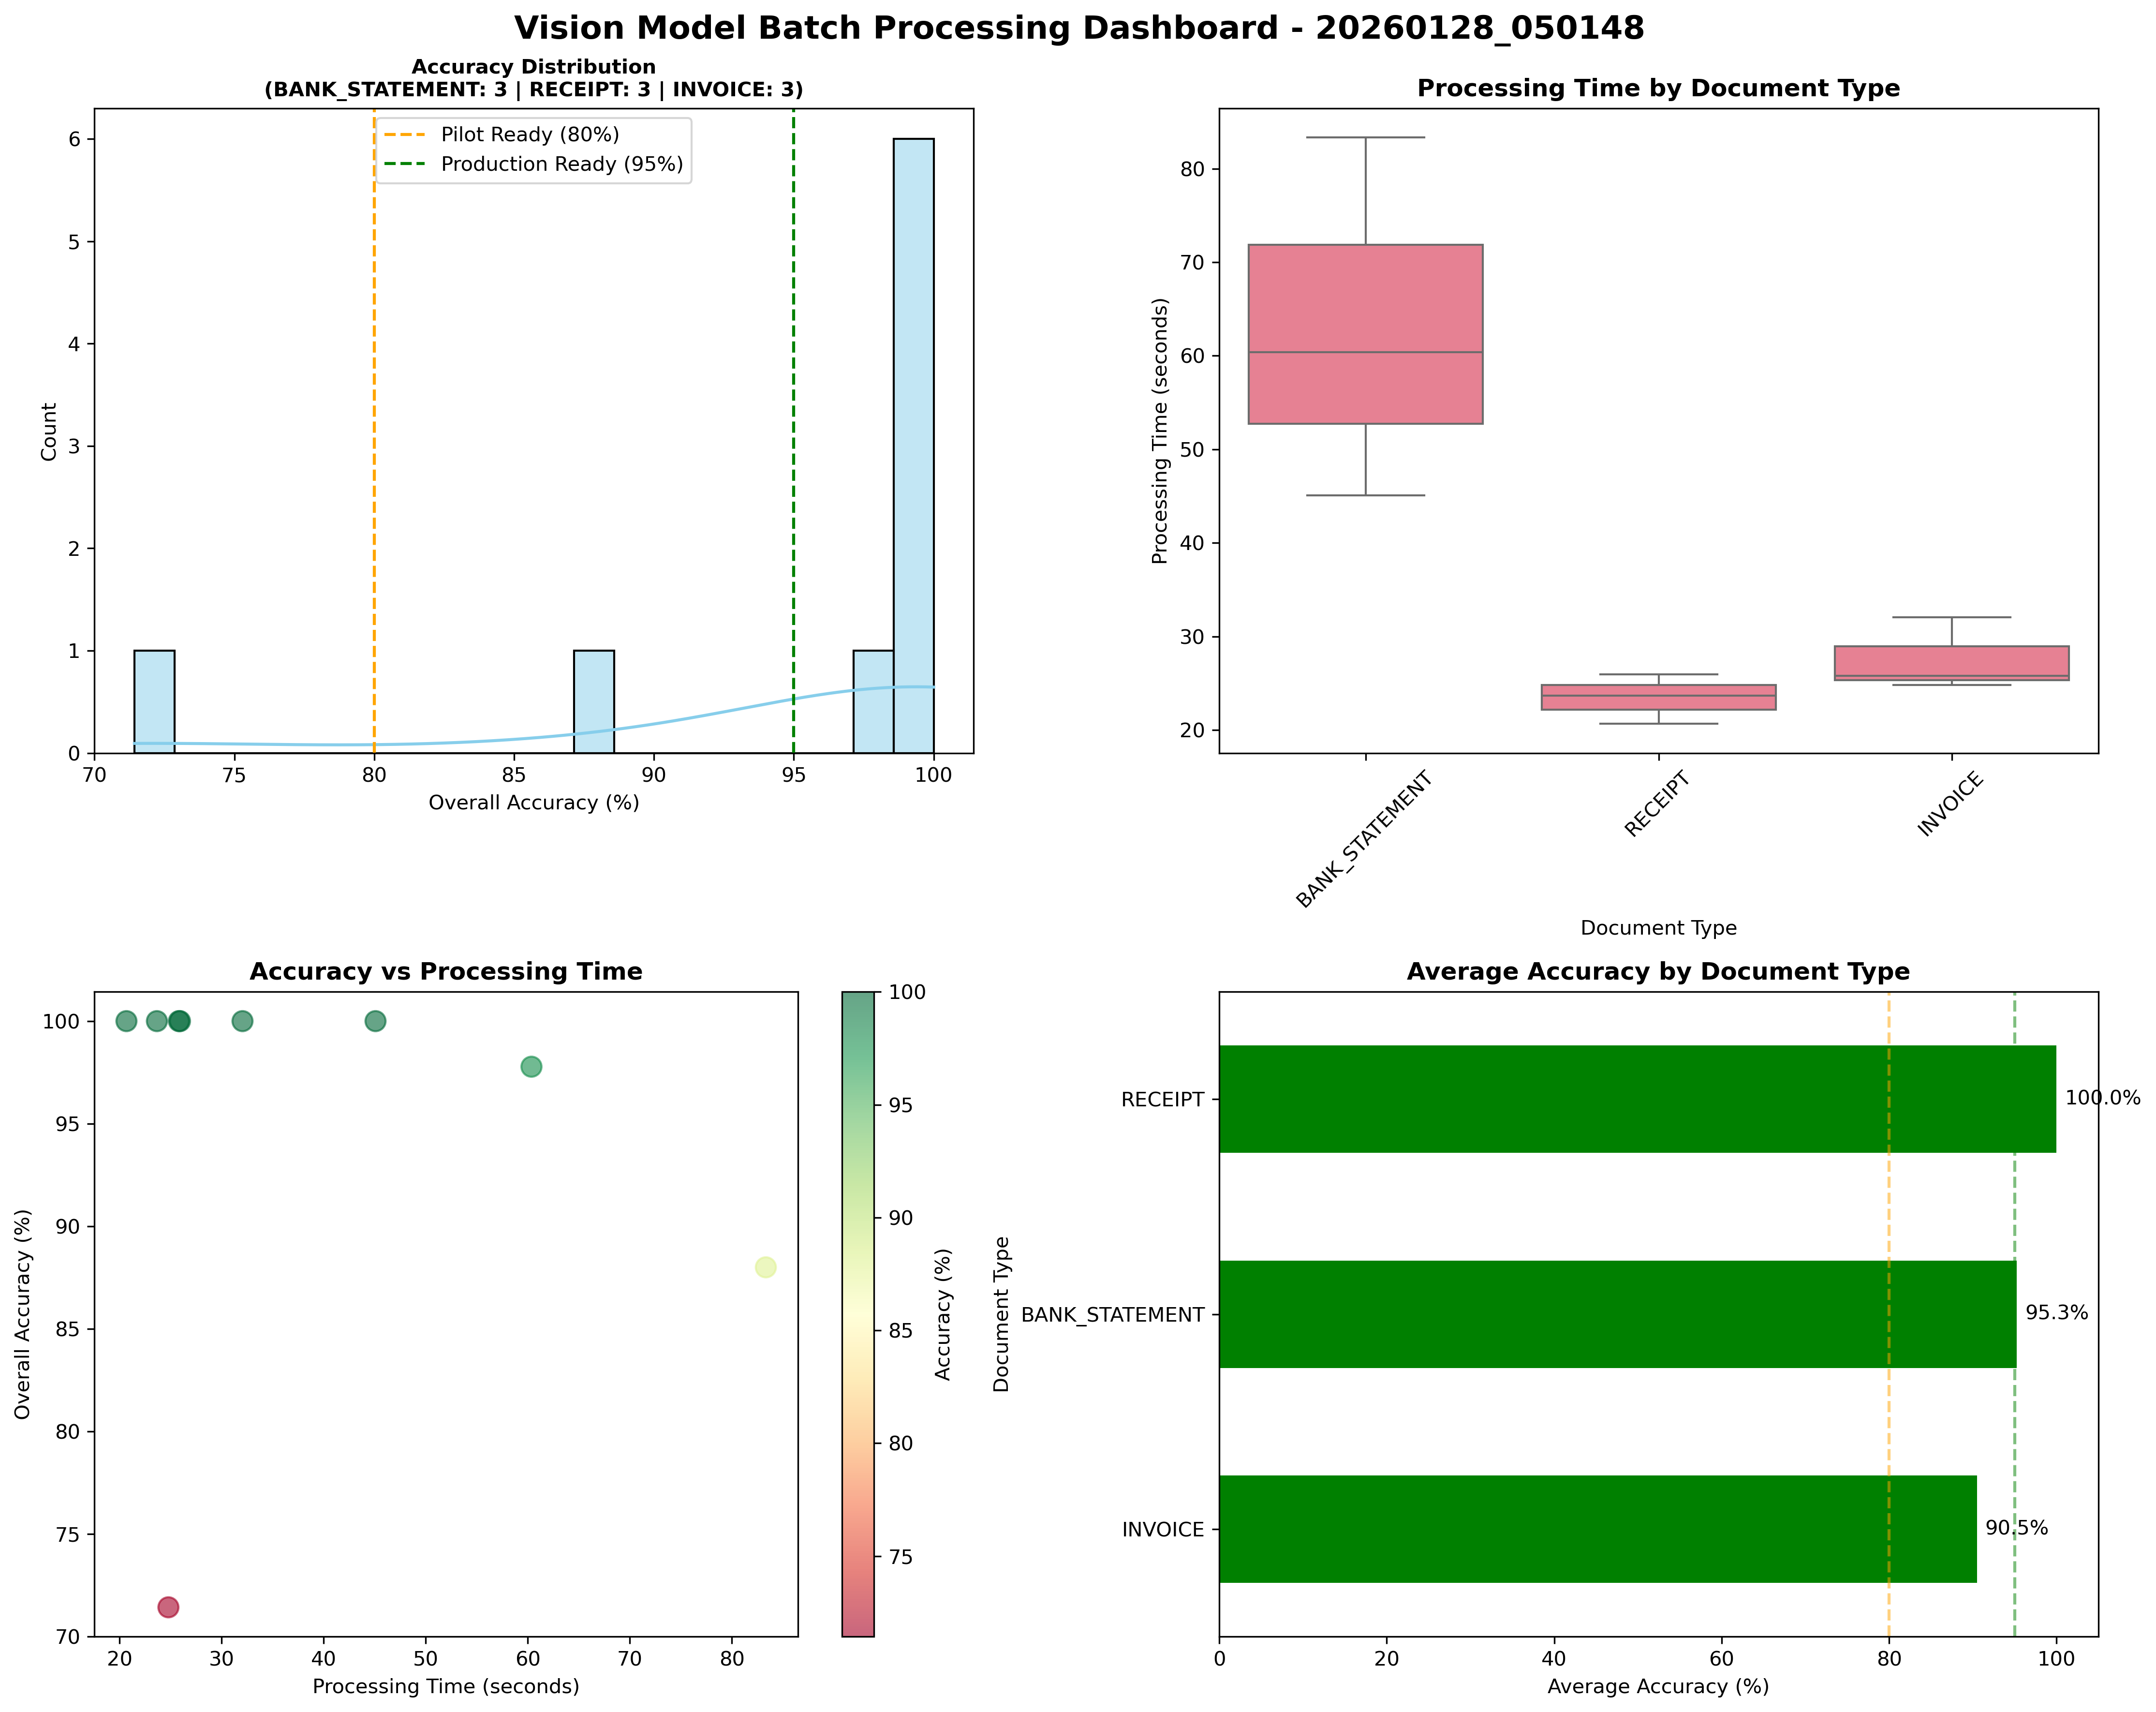

In [13]:
#Cell 12
# Display final summary
console.rule("[bold green]InternVL3.5-8B Batch Processing Complete[/bold green]")

total_images = len(batch_results)
successful = len([r for r in batch_results if 'error' not in r])
avg_accuracy = df_results['overall_accuracy'].mean() if len(df_results) > 0 else 0

rprint(f"[bold green]✅ Processed: {total_images} images[/bold green]")
rprint(f"[cyan]Success Rate: {(successful/total_images*100):.1f}%[/cyan]")
rprint(f"[cyan]Overall Average Accuracy (across all images): {avg_accuracy:.2f}%[/cyan]")

# Show per-document-type breakdown
if len(df_results) > 0 and 'document_type' in df_results.columns:
    rprint("\n[bold blue]📊 Breakdown by Document Type:[/bold blue]")
    doc_type_stats = df_results.groupby('document_type').agg({
        'overall_accuracy': 'mean',
        'image_name': 'count'
    }).sort_values('overall_accuracy', ascending=False)
    
    for doc_type, row in doc_type_stats.iterrows():
        count = int(row['image_name'])
        acc = row['overall_accuracy']
        rprint(f"[cyan]  {doc_type.upper()}: {acc:.1f}% (n={count} images)[/cyan]")

rprint(f"\n[cyan]Output: {OUTPUT_BASE}[/cyan]")
rprint("[blue]🚀 Model: InternVL3.5-8B with Cascade RL and ViR[/blue]")

# Performance assessment
if successful == total_images and avg_accuracy > 50:
    rprint("\n[bold green]🎉 SUCCESS: InternVL3.5-8B processing completed successfully![/bold green]")
    rprint("[green]✅ Enhanced reasoning with Cascade RL is working[/green]")
    rprint("[green]✅ Dynamic resolution adjustment with ViR is active[/green]")
elif successful < total_images:
    rprint("\n[bold red]❌ FAILURE: Processing errors occurred[/bold red]")
    rprint("[red]🔍 Review error logs for diagnostic information[/red]")
elif avg_accuracy < 30:
    rprint("\n[bold yellow]⚠️ POOR PERFORMANCE: Low accuracy detected[/bold yellow]")
    rprint("[yellow]🔍 Review extraction results for quality issues[/yellow]")
else:
    rprint("\n[bold blue]📊 MIXED RESULTS: Partially working[/bold blue]")
    rprint("[blue]🔍 Review individual results to assess performance[/blue]")

# Document type distribution
if document_types_found:
    rprint("\n[bold blue]📋 Document Type Distribution:[/bold blue]")
    for doc_type, count in document_types_found.items():
        percentage = (count / total_images * 100) if total_images > 0 else 0
        rprint(f"[cyan]  {doc_type}: {count} documents ({percentage:.1f}%)[/cyan]")

# Display dashboard if available
dashboard_files = list(OUTPUT_DIRS['visualizations'].glob(f"dashboard_{BATCH_TIMESTAMP}.png"))
if dashboard_files:
    from IPython.display import Image, display
    dashboard_path = dashboard_files[0]
    rprint("\n[bold blue]📊 Visual Dashboard:[/bold blue]")
    display(Image(str(dashboard_path)))
else:
    rprint(f"\n[yellow]⚠️ Dashboard not found in {OUTPUT_DIRS['visualizations']}[/yellow]")

## 13. Failed Extractions

In [14]:
#Cell 13
# Calculate zero accuracy extractions
zero_accuracy_count = 0
zero_accuracy_images = []
total_evaluated = 0

for result in batch_results:
    # Check if evaluation data exists (not inference-only mode)
    evaluation = result.get("evaluation", {})

    if evaluation and not evaluation.get("inference_only", False):
        total_evaluated += 1
        accuracy = evaluation.get("overall_accuracy", 0)

        if accuracy == 0.0:
            zero_accuracy_count += 1
            zero_accuracy_images.append(
                {
                    "image_name": result.get("image_name", "unknown"),
                    "document_type": result.get("document_type", "unknown"),
                    "fields_extracted": evaluation.get("fields_extracted", 0),
                    "total_fields": evaluation.get("total_fields", 0),
                }
            )

# Display results
if total_evaluated > 0:
    console.rule("[bold red]Zero Accuracy Analysis[/bold red]")

    rprint(f"[cyan]Total documents evaluated: {total_evaluated}[/cyan]")
    rprint(f"[red]Documents with 0% accuracy: {zero_accuracy_count}[/red]")

    if zero_accuracy_count > 0:
        percentage = (zero_accuracy_count / total_evaluated) * 100
        rprint(f"[red]Zero accuracy rate: {percentage:.1f}%[/red]")

        rprint("\n[bold red]Documents with 0% Accuracy:[/bold red]")
        for i, img_info in enumerate(zero_accuracy_images, 1):
            rprint(f"  {i}. {img_info['image_name']} ({img_info['document_type']})")
            rprint(
                f"     Fields extracted: {img_info['fields_extracted']}/{img_info['total_fields']}"
            )
    else:
        rprint(
            "[green]✅ No documents with 0% accuracy - all extractions had some success![/green]"
        )
else:
    rprint(
        "[yellow]⚠️ Running in inference-only mode - no accuracy metrics available[/yellow]"
    )


───────────────────────────────────────────── Zero Accuracy Analysis ──────────────────────────────────────────────

Total documents evaluated: 9

Documents with 0% accuracy: 0

✅ No documents with 0% accuracy - all extractions had some success!